In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import boxcox_normmax, boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.special import inv_boxcox



pd.set_option('display.max_columns', None)

In [2]:
cities = ["amsterdam", "athens", "barcelona", "berlin", "budapest", "lisbon", "london", "paris", "rome", "vienna"]
types = ["weekdays", "weekends"]

df = []
for city in cities:
    for day in types:
        filename = f'archive/{city}_{day}.csv'
        dataframe = pd.read_csv(filename, index_col = 0)
        dataframe['city'] = city
        dataframe['day_of_week'] = day
        df.append(dataframe)

df = pd.concat(df).reset_index(drop=True)
df

realSum        room_type  room_shared  room_private  \
0      194.033698     Private room        False          True   
1      344.245776     Private room        False          True   
2      264.101422     Private room        False          True   
3      433.529398     Private room        False          True   
4      485.552926     Private room        False          True   
...           ...              ...          ...           ...   
51702  715.938574  Entire home/apt        False         False   
51703  304.793960  Entire home/apt        False         False   
51704  637.168969  Entire home/apt        False         False   
51705  301.054157     Private room        False          True   
51706  133.230489     Private room        False          True   

       person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                  2.0              False      1    0                10.0   
1                  4.0              False      0    0                 8.0   
2                  2.0              False      0    1                 9.0   
3                  4.0              False      0    1                 9.0   
4                  2.0               True      0    0                10.0   
...                ...                ...    ...  ...                 ...   
51702              6.0              False      0    1                10.0   
51703              2.0              False      0    0                 8.0   
51704              2.0              False      0    0                10.0   
51705              2.0              False      0    0                10.0   
51706              4.0               True      1    0                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                            93.0         1  5.022964    2.539380   78.690379   
1                            85.0         1  0.488389    0.239404  631.176378   
2                            87.0         1  5.748312    3.651621   75.275877   
3                            90.0         2  0.384862    0.439876  493.272534   
4                            98.0         1  0.544738    0.318693  552.830324   
...                           ...       ...       ...         ...         ...   
51702                       100.0         3  0.530181    0.135447  219.402478   
51703                        86.0         1  0.810205    0.100839  204.970121   
51704                        93.0         1  0.994051    0.202539  169.073402   
51705                        87.0         1  3.044100    0.287435  109.236574   
51706                        93.0         1  1.263932    0.480903  150.450381   

       attr_index_norm  rest_index  rest_index_norm       lng       lat  \
0             4.166708   98.253896         6.846473   4.90569  52.41772   
1            33.421209  837.280757        58.342928   4.90005  52.37432   
2             3.985908   95.386955         6.646700   4.97512  52.36103   
3            26.119108  875.033098        60.973565   4.89417  52.37663   
4            29.272733  815.305740        56.811677   4.90051  52.37508   
...                ...         ...              ...       ...       ...   
51702        15.712158  438.756874        10.604584  16.37940  48.21136   
51703        14.678608  342.182813         8.270427  16.38070  48.20296   
51704        12.107921  282.296424         6.822996  16.38568  48.20460   
51705         7.822803  158.563398         3.832416  16.34100  48.19200   
51706        10.774264  225.247293         5.444140  16.39066  48.20811   

            city day_of_week  
0      amsterdam    weekdays  
1      amsterdam    weekdays  
2      amsterdam    weekdays  
3      amsterdam    weekdays  
4      amsterdam    weekdays  
...          ...         ...  
51702     vienna    weekends  
51703     vienna    weekends  
51704     vienna    weekends  
51705     vienna    weekends  
51706     vienna    weekends  

[51707 rows x 21 columns]

In [3]:
df['realSum'].describe()

count    51707.000000
mean       279.879591
std        327.948386
min         34.779339
25%        148.752174
50%        211.343089
75%        319.694287
max      18545.450285
Name: realSum, dtype: float64

In [4]:
df.isnull().sum()

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
day_of_week                   0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

In [6]:
df[['multi', 'biz']] = df[['multi', 'biz']].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  bool   
 7   biz                         51707 non-null  bool   
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

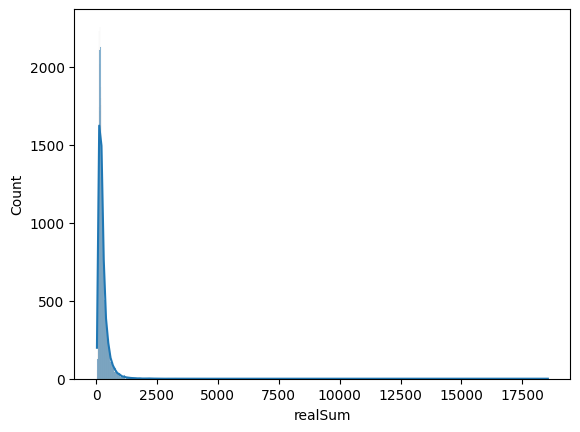

21.419956563350983


In [7]:
target_skewness = df['realSum'].skew()
sns.histplot(df['realSum'], kde=True)
plt.show()
print(target_skewness)

In [8]:
def plot_scatter(features, target, df):
    
    for feature in features:
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=feature, y=target, data=df, legend=False)
        plt.title(f'Scatter Plot of {feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.show()

### Plot initial scatterplot to check for linearity

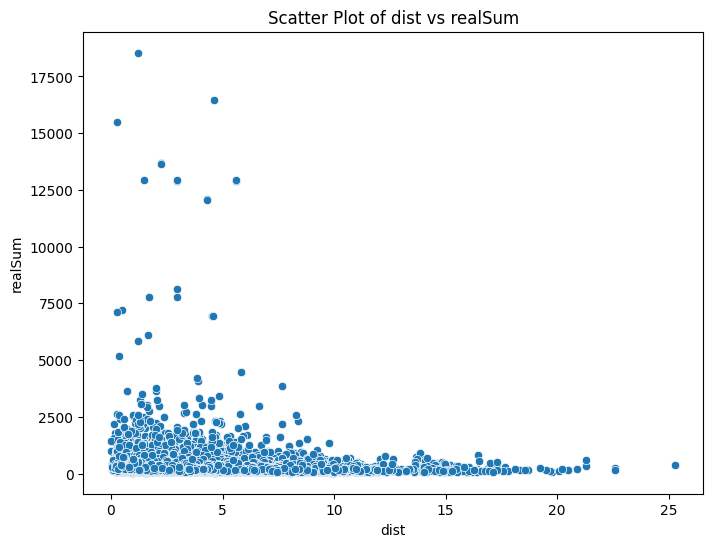

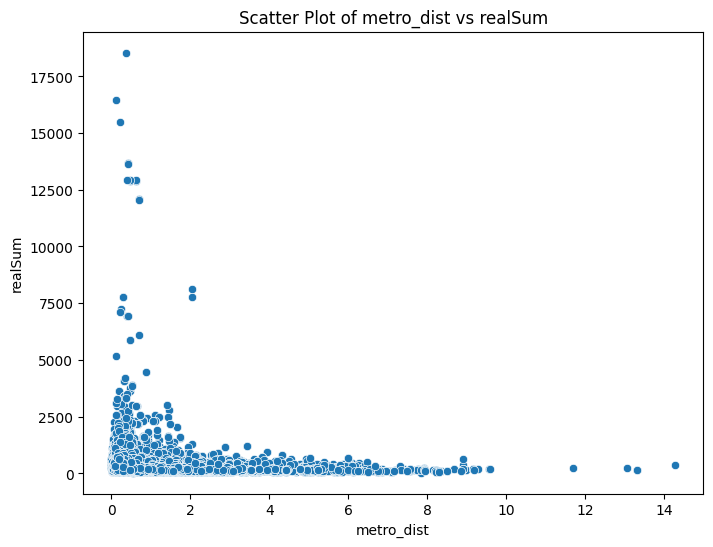

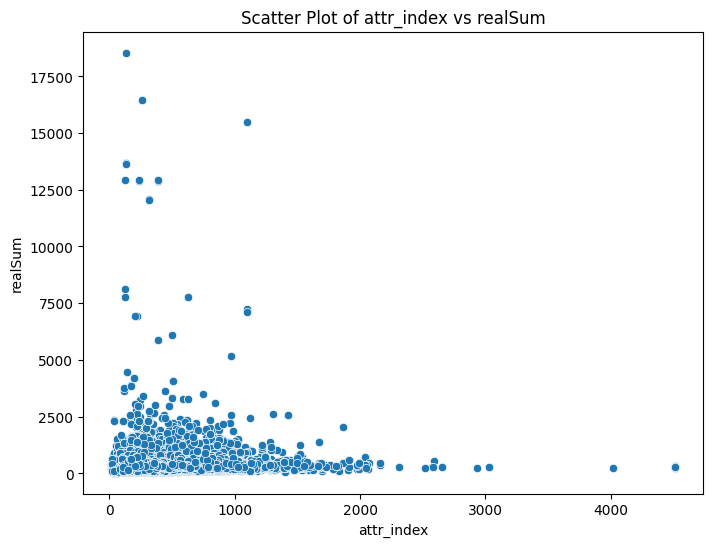

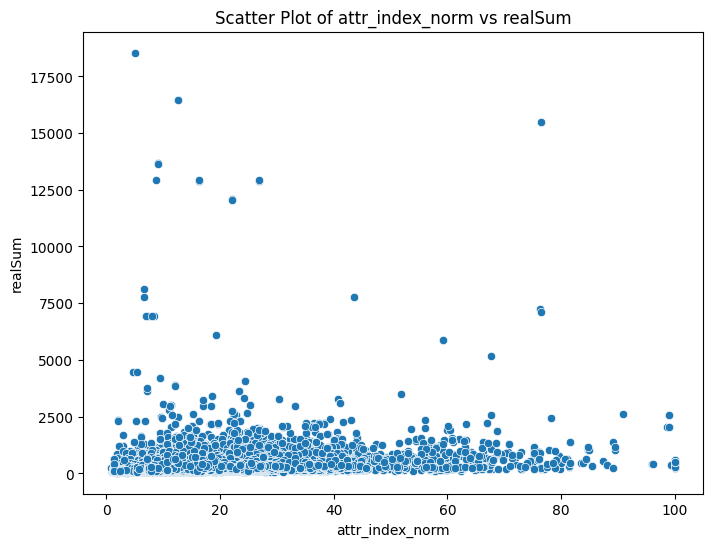

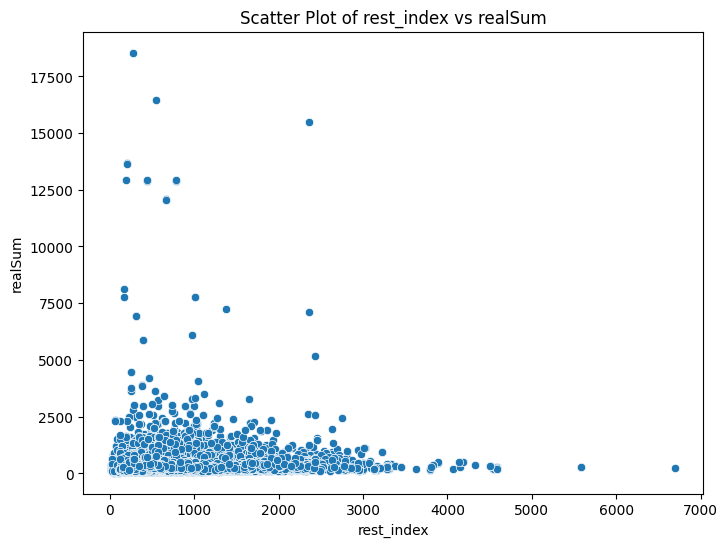

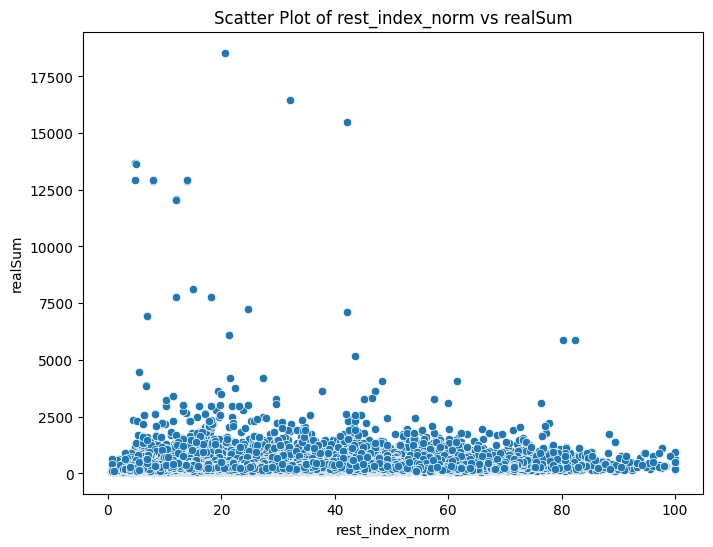

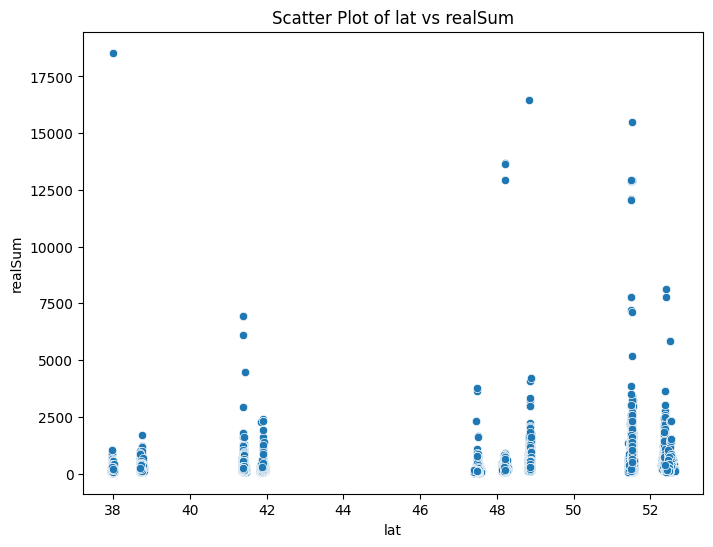

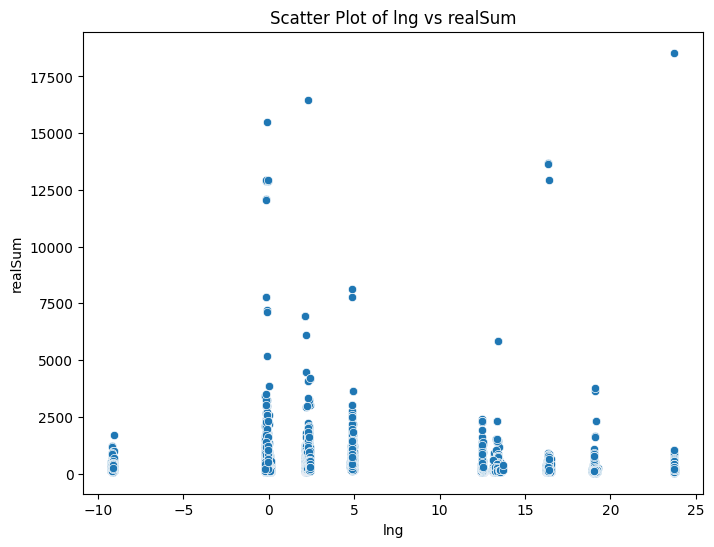

In [9]:
plot_scatter(['dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lat', 'lng'], 'realSum', df)

### there is no linear relationships and y variable is extremely skewed - let's transform

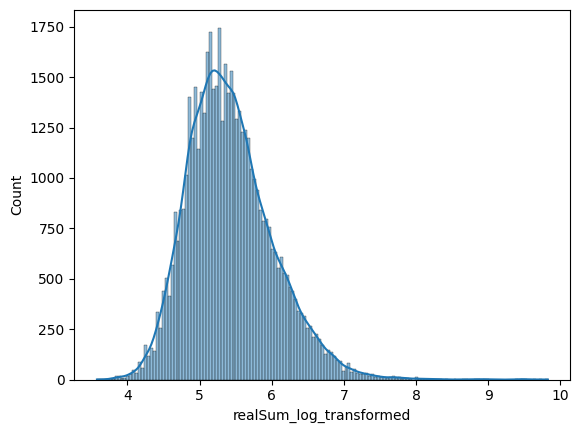

0.7172303263400415


In [10]:
df['realSum_log_transformed'] = np.log1p(df['realSum'])
target_skewness = df['realSum_log_transformed'].skew()
sns.histplot(df['realSum_log_transformed'], kde=True)
plt.show()
print(target_skewness)

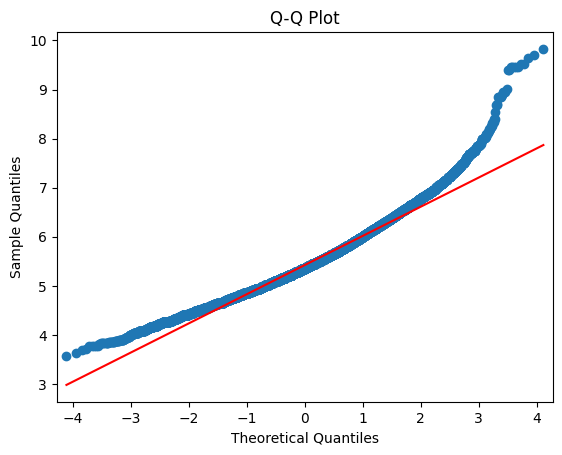

In [11]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

qqplot(df['realSum_log_transformed'], line='s')  # 's' denotes standardized line
plt.title('Q-Q Plot')
plt.show()

### Log transformation is not ideal in terms of normality, let's try boxcox

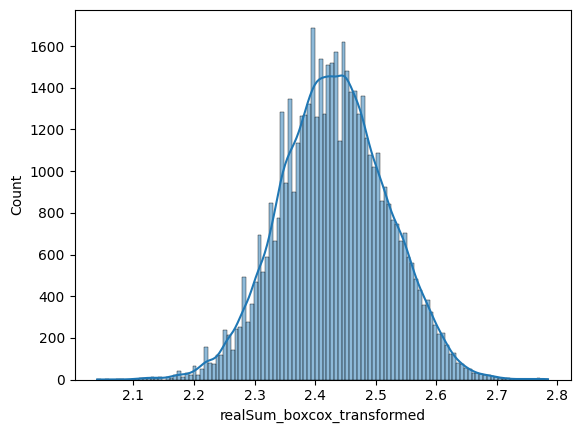

-0.00023544792353121186


In [12]:
df['realSum_boxcox_transformed'], fitted_y_lambda = boxcox(df['realSum'])
target_skewness = df['realSum_boxcox_transformed'].skew()
sns.histplot(df['realSum_boxcox_transformed'], kde=True)
plt.show()
print(target_skewness)

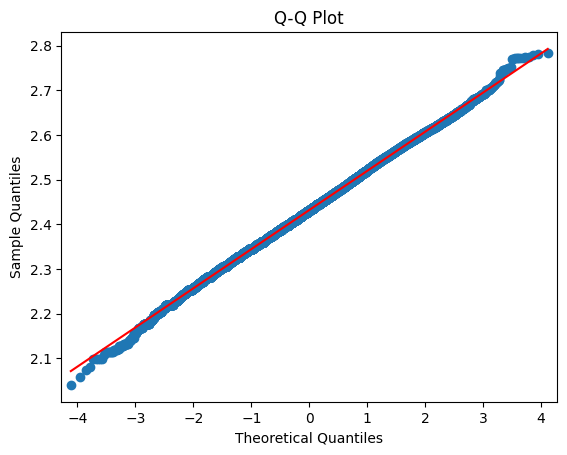

In [13]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

qqplot(df['realSum_boxcox_transformed'], line='s')  # 's' denotes standardized line
plt.title('Q-Q Plot')
plt.show()

### Log transformations still show non-normality, boxcox shows better results in this case

In [14]:
df = df.drop('realSum_log_transformed', axis=1)

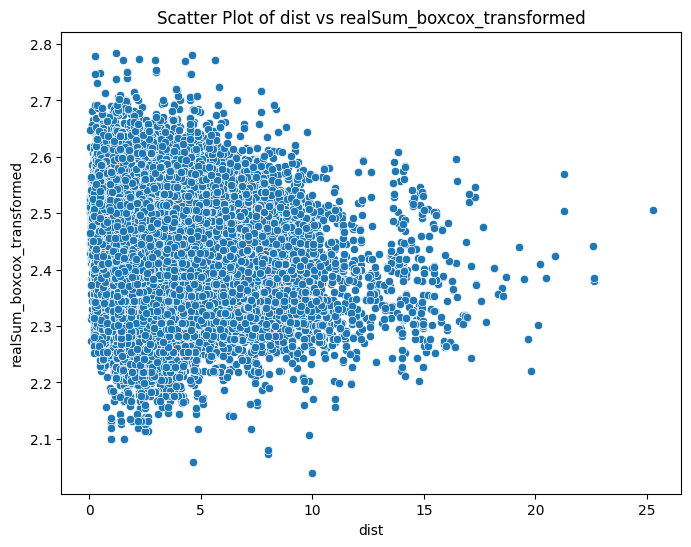

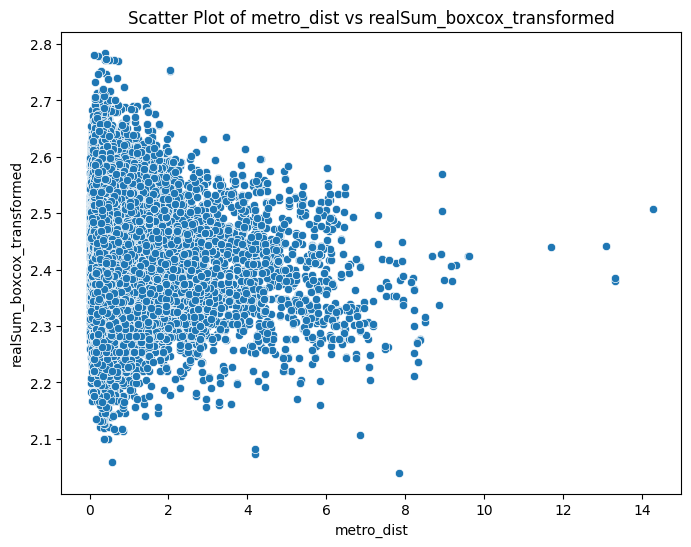

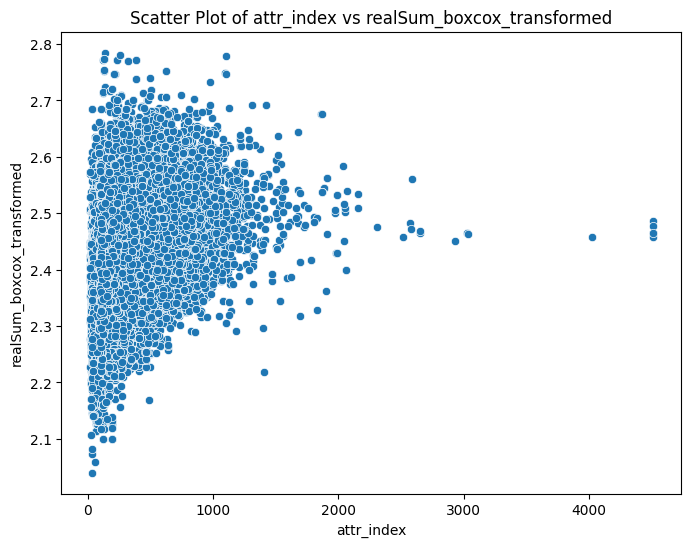

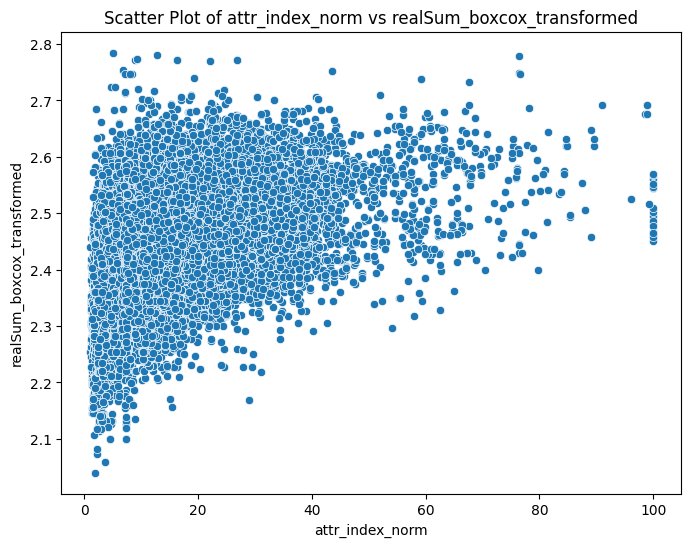

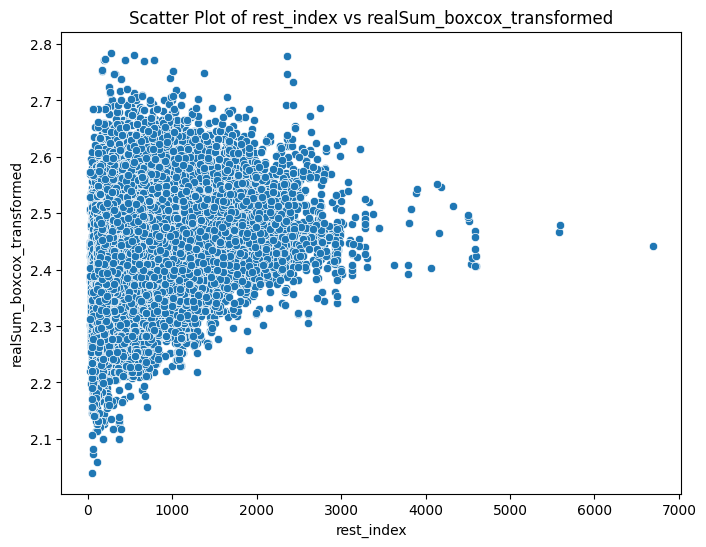

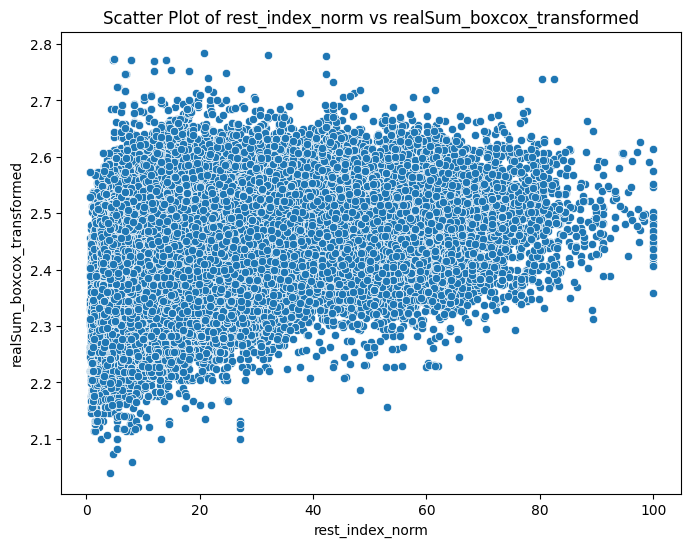

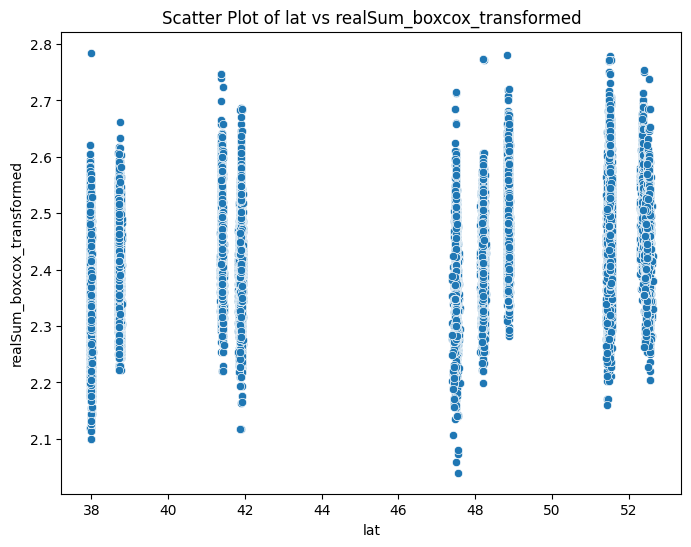

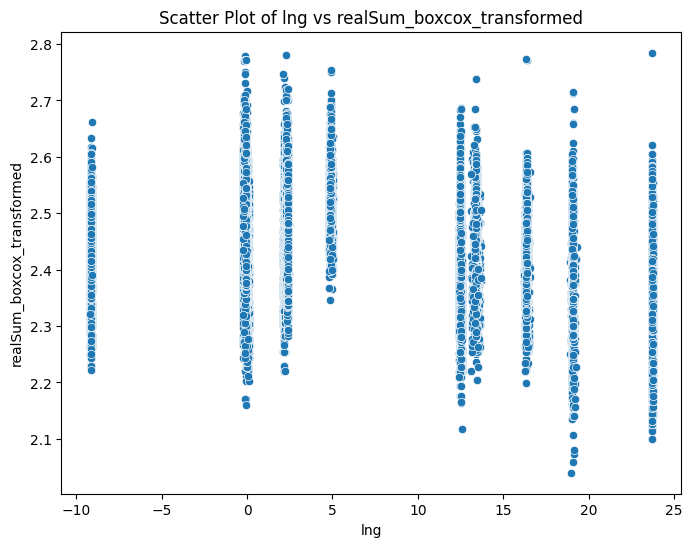

In [15]:
plot_scatter(['dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lat', 'lng'], 'realSum_boxcox_transformed', df)

### Better than before, but still not linear

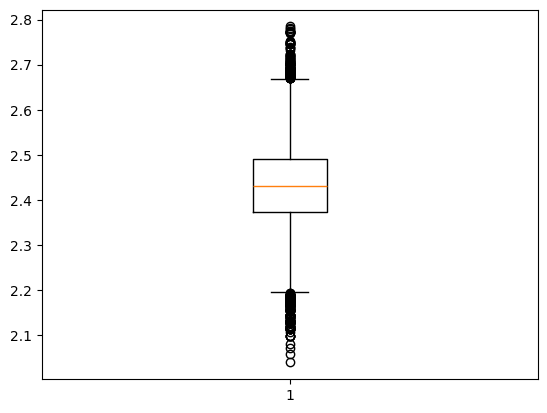

In [16]:
plt.boxplot(df['realSum_boxcox_transformed']) 
plt.show()

### Since there exists non-linear relationships even after transforming y, let's transform X features and plot against y and the transformed y

In [17]:
continuous = df.select_dtypes(include=np.number).drop(['person_capacity', 'cleanliness_rating', 'bedrooms', 'guest_satisfaction_overall', 'realSum', 'realSum_boxcox_transformed'], axis =1)
continuous.head()

dist  metro_dist  attr_index  attr_index_norm  rest_index  \
0  5.022964    2.539380   78.690379         4.166708   98.253896   
1  0.488389    0.239404  631.176378        33.421209  837.280757   
2  5.748312    3.651621   75.275877         3.985908   95.386955   
3  0.384862    0.439876  493.272534        26.119108  875.033098   
4  0.544738    0.318693  552.830324        29.272733  815.305740   

   rest_index_norm      lng       lat  
0         6.846473  4.90569  52.41772  
1        58.342928  4.90005  52.37432  
2         6.646700  4.97512  52.36103  
3        60.973565  4.89417  52.37663  
4        56.811677  4.90051  52.37508

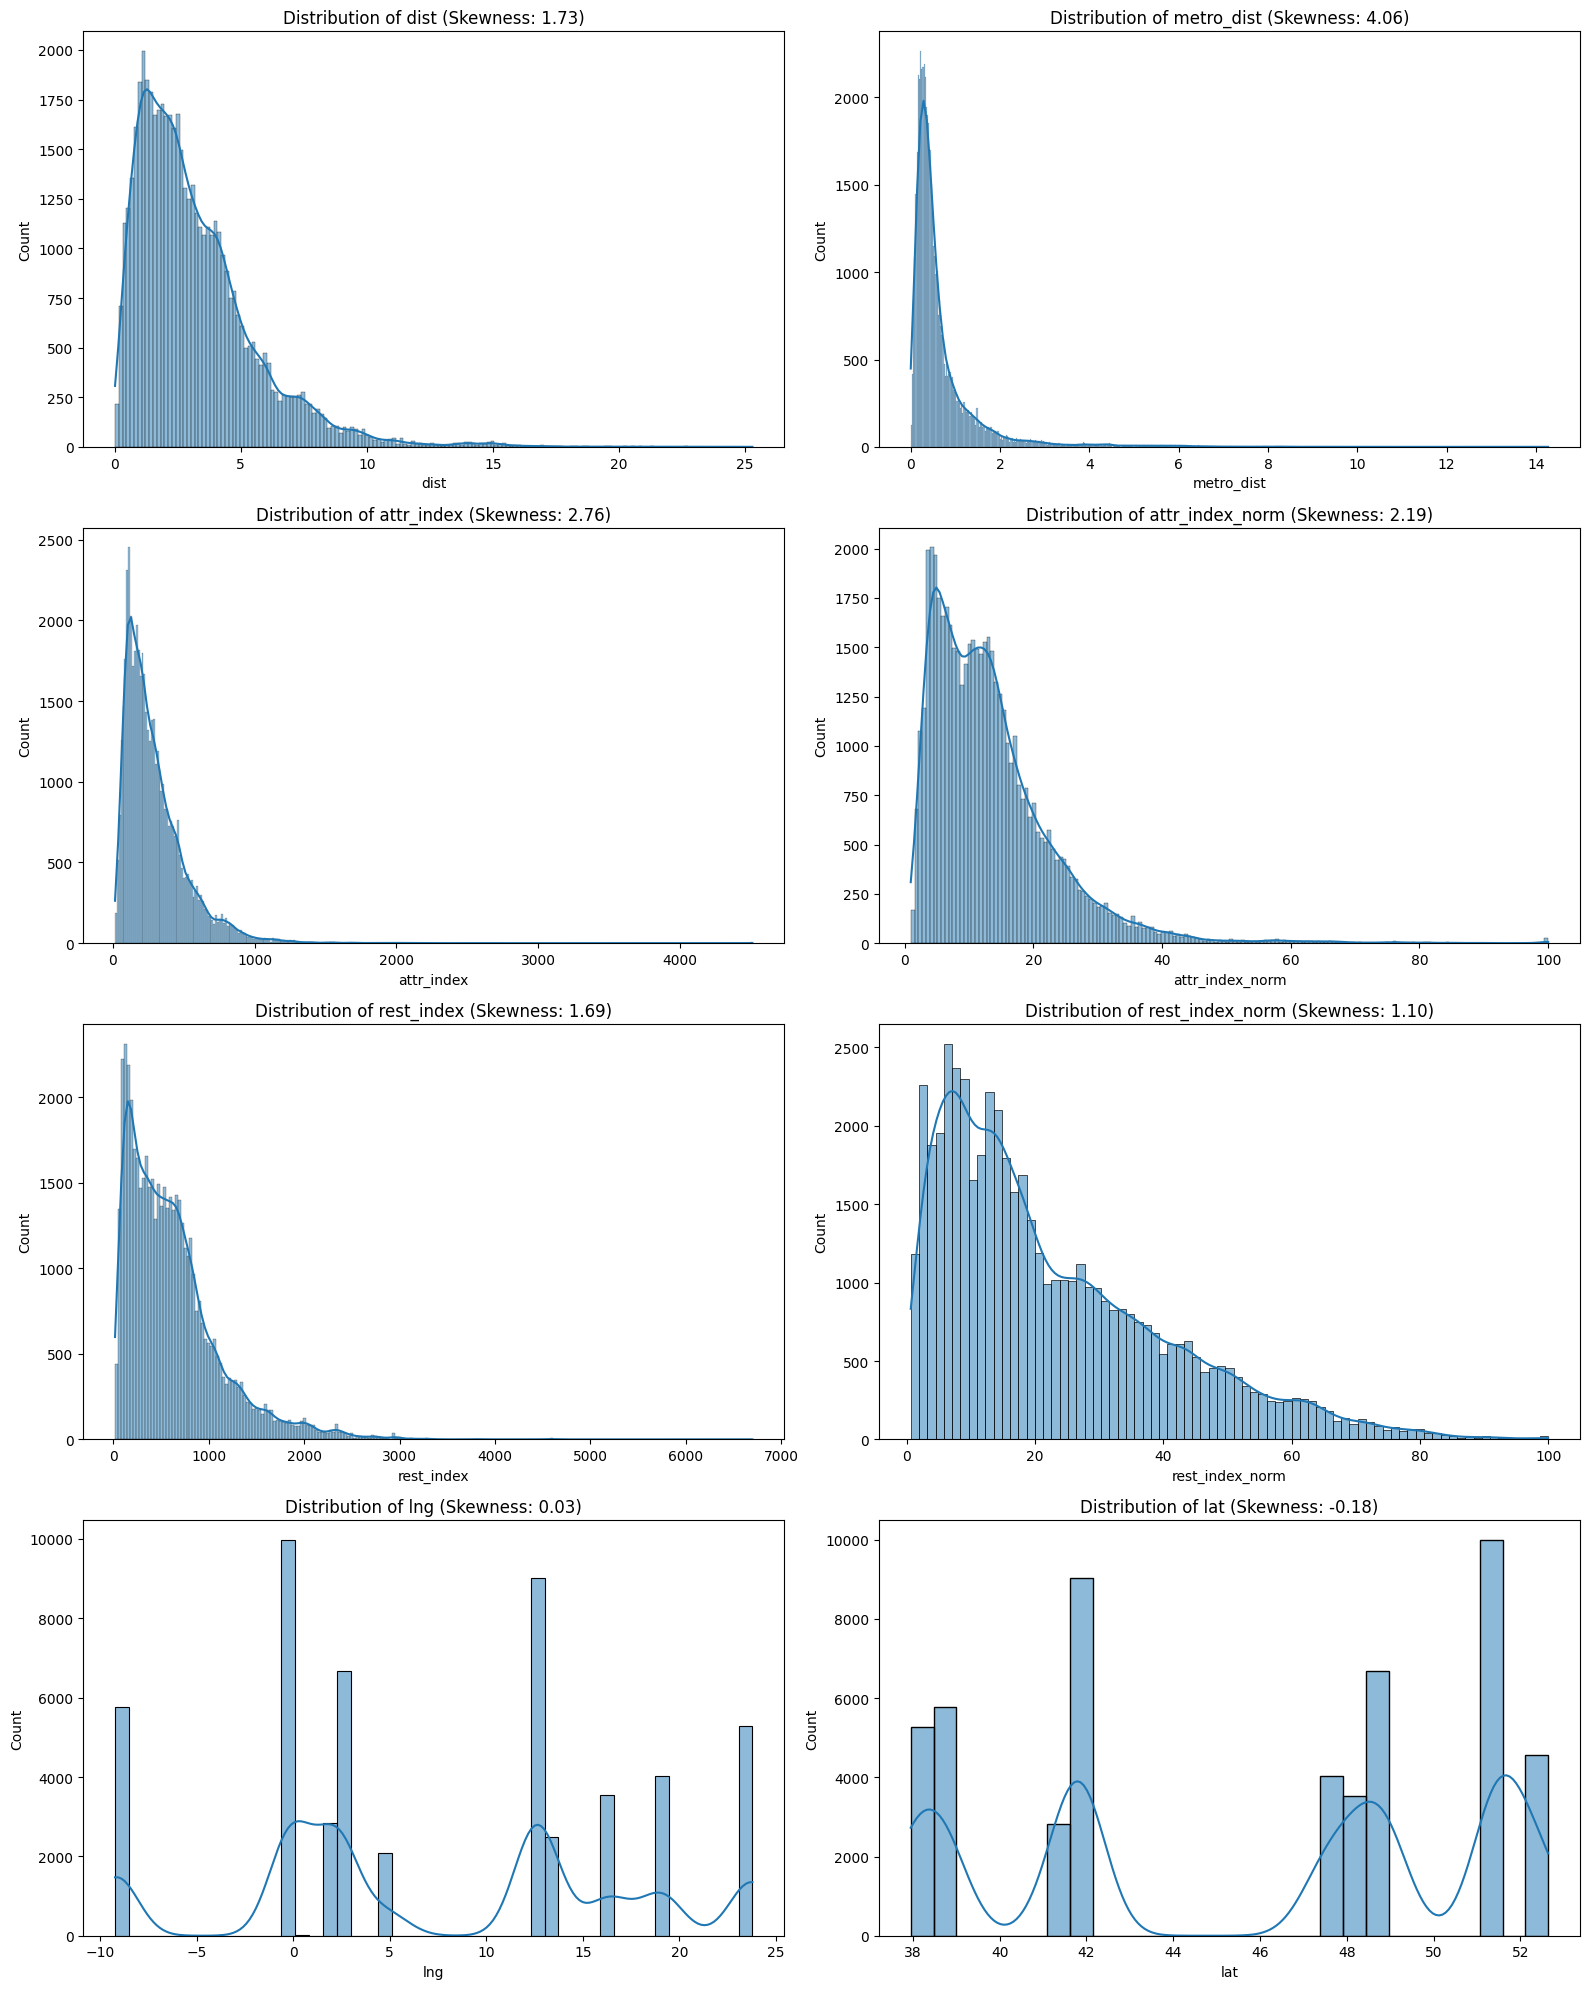

dist               1.731195
metro_dist         4.060445
attr_index         2.759981
attr_index_norm    2.193167
rest_index         1.694356
rest_index_norm    1.097455
lng                0.033301
lat               -0.179583
dtype: float64


In [18]:
def plot_histograms(df):
    skewness = df.skew()
    nrows = int(len(df.columns) / 2)

    fig, axes = plt.subplots(nrows, int(len(df.columns)/nrows), figsize=(16, 20))
    axes = axes.flatten()
    for i, col in enumerate(df):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
    
    plt.tight_layout()
    plt.show()
    print(skewness)

plot_histograms(continuous)

### Features are very skewed, and given the fact that it does not have a linear relationship even with the transformed y, we will transform the features

In [19]:
features_to_transform = ['dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm']

for col in features_to_transform:
    df[f"{col}_transformed"], fitted_feature_lambda = boxcox(df[col])
    
df

realSum        room_type  room_shared  room_private  \
0      194.033698     Private room        False          True   
1      344.245776     Private room        False          True   
2      264.101422     Private room        False          True   
3      433.529398     Private room        False          True   
4      485.552926     Private room        False          True   
...           ...              ...          ...           ...   
51702  715.938574  Entire home/apt        False         False   
51703  304.793960  Entire home/apt        False         False   
51704  637.168969  Entire home/apt        False         False   
51705  301.054157     Private room        False          True   
51706  133.230489     Private room        False          True   

       person_capacity  host_is_superhost  multi    biz  cleanliness_rating  \
0                  2.0              False   True  False                10.0   
1                  4.0              False  False  False                 8.0   
2                  2.0              False  False   True                 9.0   
3                  4.0              False  False   True                 9.0   
4                  2.0               True  False  False                10.0   
...                ...                ...    ...    ...                 ...   
51702              6.0              False  False   True                10.0   
51703              2.0              False  False  False                 8.0   
51704              2.0              False  False  False                10.0   
51705              2.0              False  False  False                10.0   
51706              4.0               True   True  False                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                            93.0         1  5.022964    2.539380   78.690379   
1                            85.0         1  0.488389    0.239404  631.176378   
2                            87.0         1  5.748312    3.651621   75.275877   
3                            90.0         2  0.384862    0.439876  493.272534   
4                            98.0         1  0.544738    0.318693  552.830324   
...                           ...       ...       ...         ...         ...   
51702                       100.0         3  0.530181    0.135447  219.402478   
51703                        86.0         1  0.810205    0.100839  204.970121   
51704                        93.0         1  0.994051    0.202539  169.073402   
51705                        87.0         1  3.044100    0.287435  109.236574   
51706                        93.0         1  1.263932    0.480903  150.450381   

       attr_index_norm  rest_index  rest_index_norm       lng       lat  \
0             4.166708   98.253896         6.846473   4.90569  52.41772   
1            33.421209  837.280757        58.342928   4.90005  52.37432   
2             3.985908   95.386955         6.646700   4.97512  52.36103   
3            26.119108  875.033098        60.973565   4.89417  52.37663   
4            29.272733  815.305740        56.811677   4.90051  52.37508   
...                ...         ...              ...       ...       ...   
51702        15.712158  438.756874        10.604584  16.37940  48.21136   
51703        14.678608  342.182813         8.270427  16.38070  48.20296   
51704        12.107921  282.296424         6.822996  16.38568  48.20460   
51705         7.822803  158.563398         3.832416  16.34100  48.19200   
51706        10.774264  225.247293         5.444140  16.39066  48.20811   

            city day_of_week  realSum_boxcox_transformed  dist_transformed  \
0      amsterdam    weekdays                    2.417335          1.990728   
1      amsterdam    weekdays                    2.500767         -0.655784   
2      amsterdam    weekdays                    2.464258          2.196604   
3      amsterdam    weekdays                    2.529912         -0.848888   
4      amsterdam

In [20]:
#df['dist_transformed_squared'] = df['dist_transformed']**2

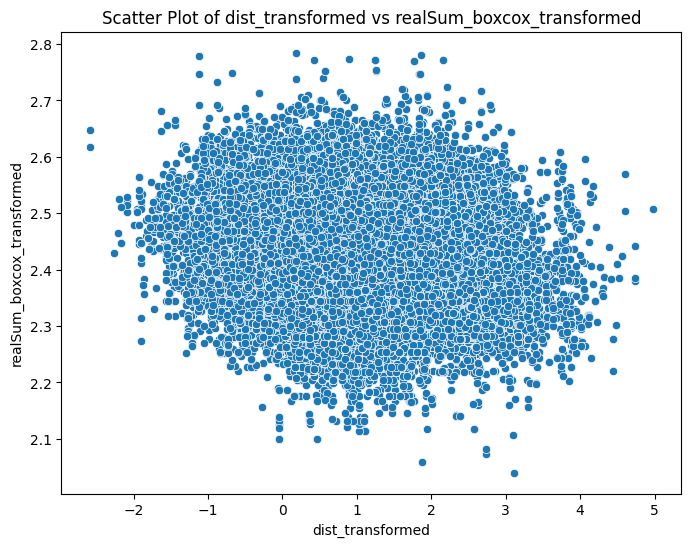

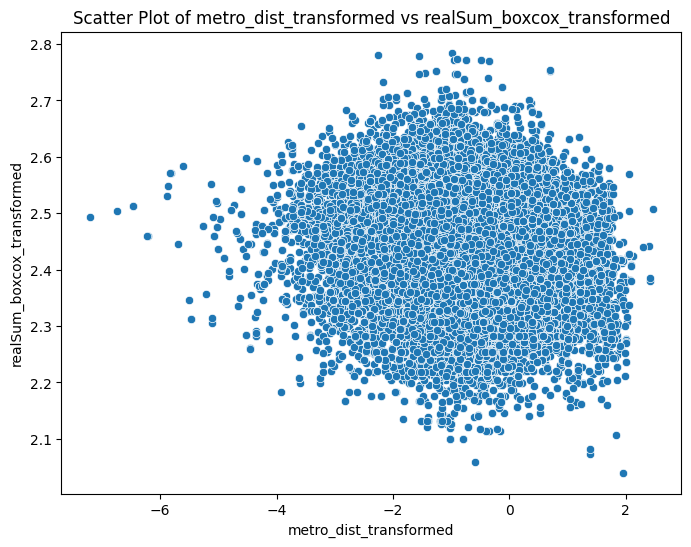

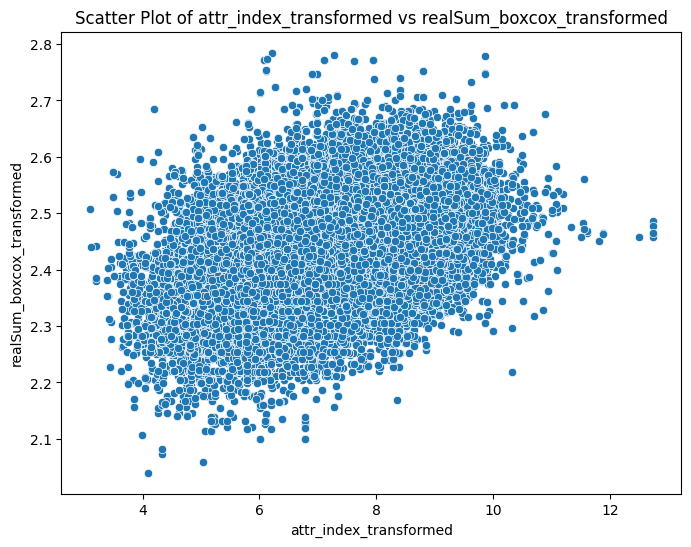

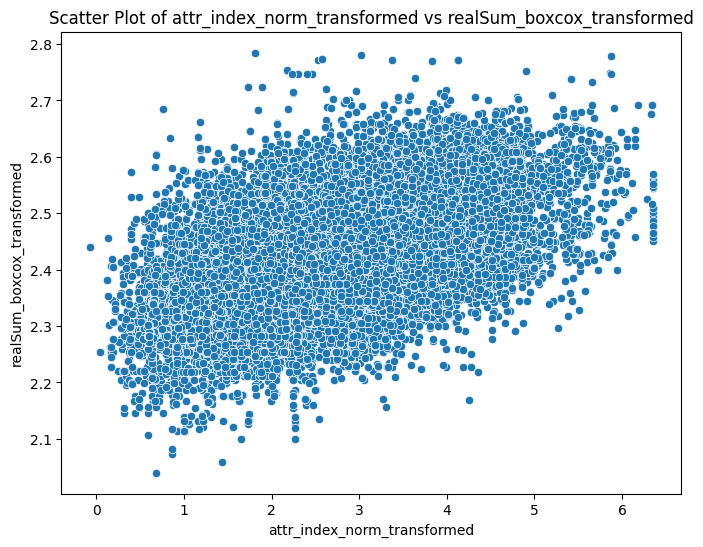

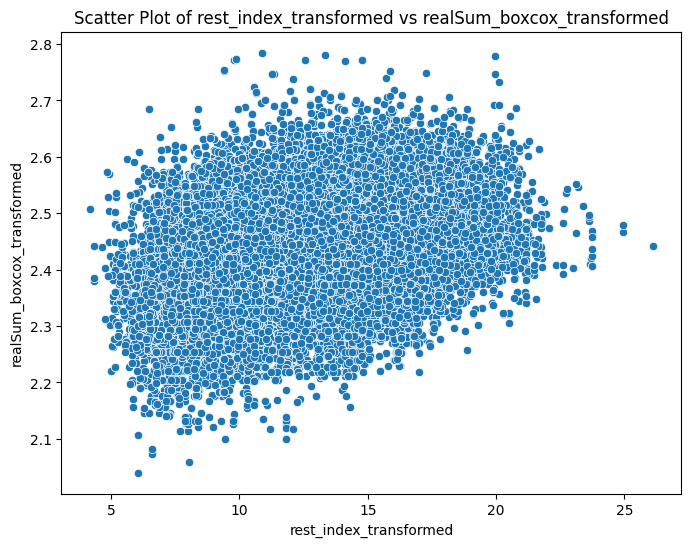

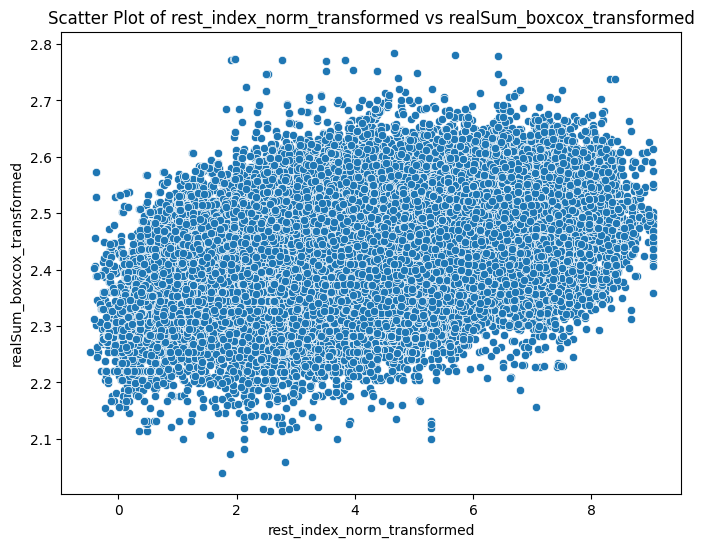

In [21]:
plot_scatter(['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed'], 
             'realSum_boxcox_transformed', df)

### Remove outliers

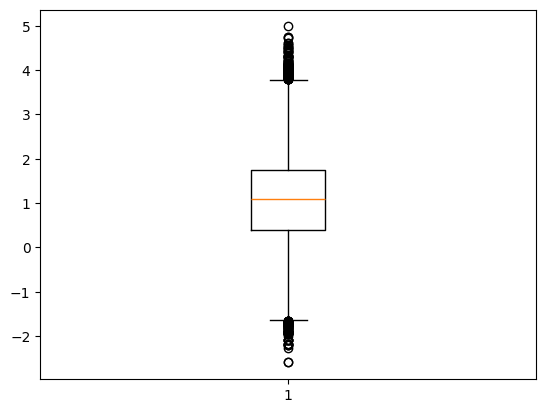

In [22]:
plt.boxplot(df['dist_transformed']) 
plt.show()

In [23]:
def remove_outliers(df, columns):
    q1 = df[columns].quantile(0.25)
    q3 = df[columns].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[columns] >= lower_bound) & (df[columns] <= upper_bound)]
    return df

features = ['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']
target = 'realSum_boxcox_transformed'

for col in features + [target]:
    df = remove_outliers(df, col)


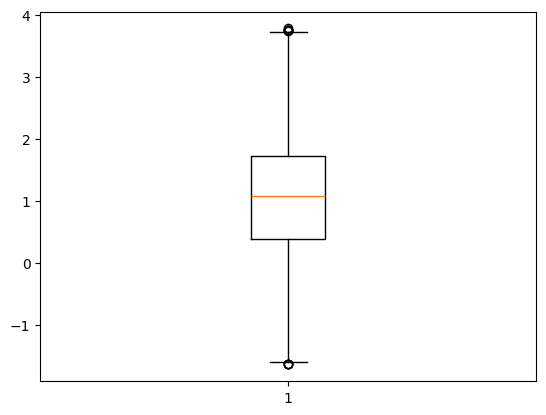

In [24]:
plt.boxplot(df['dist_transformed']) 
plt.show()

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


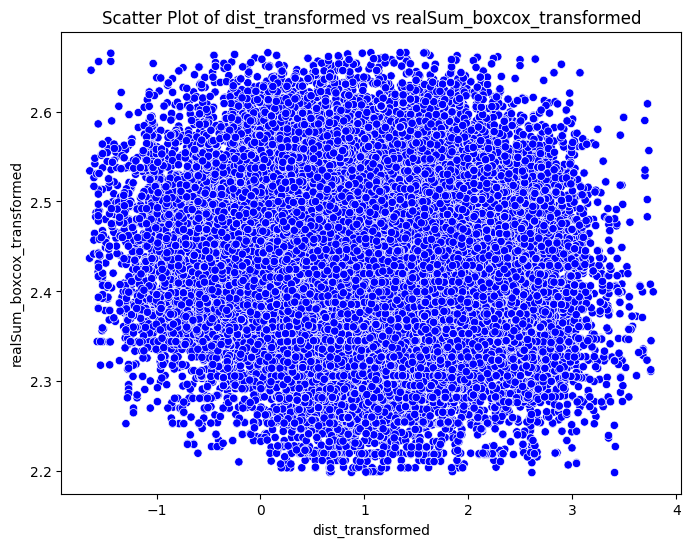

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


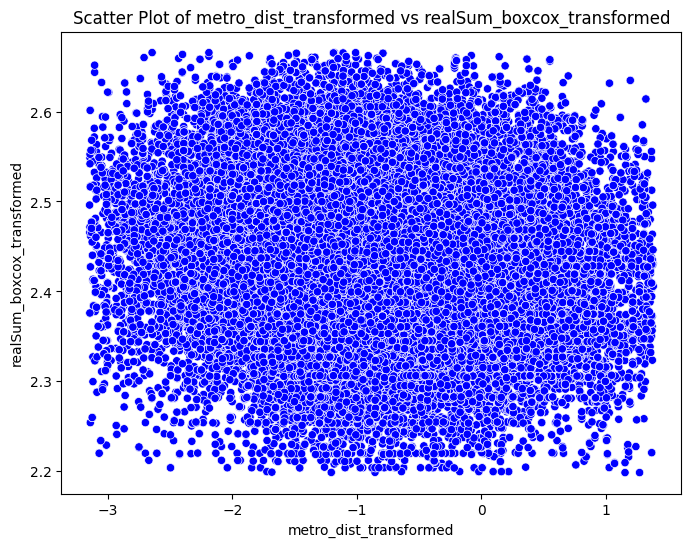

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


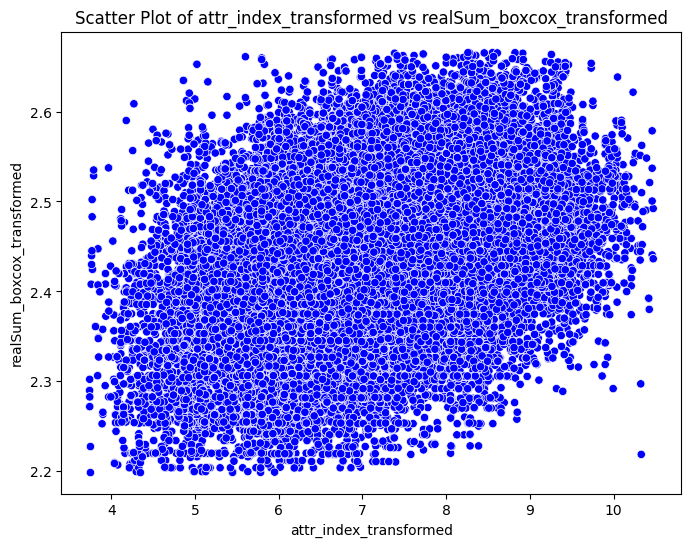

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


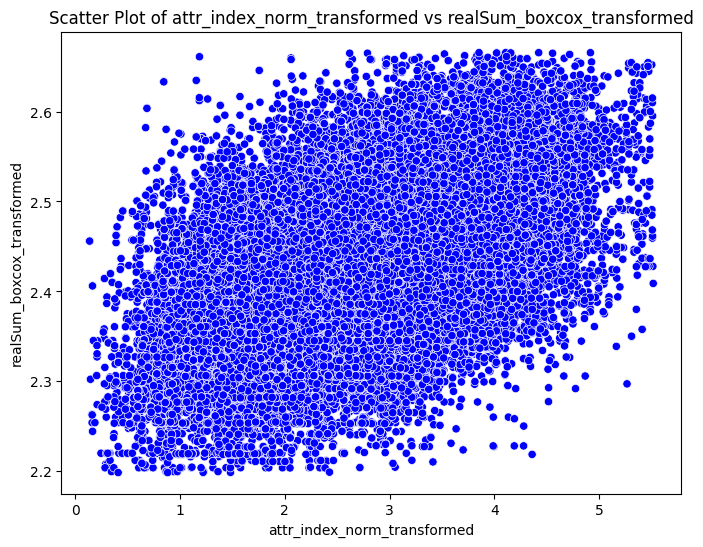

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


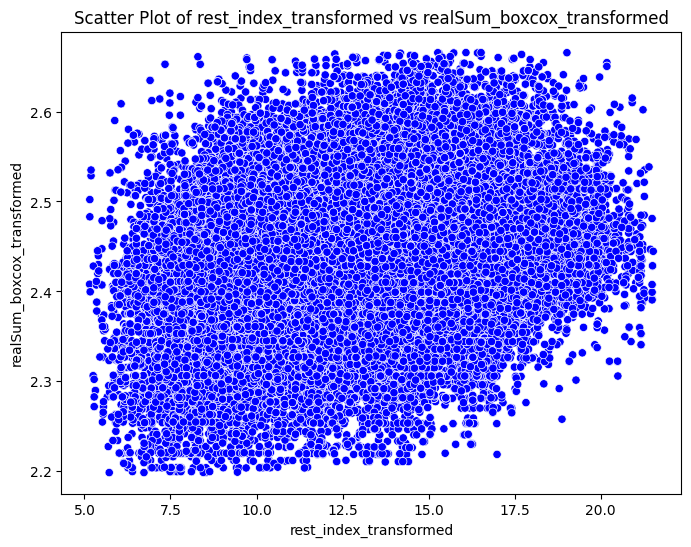

/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/1440264292.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)


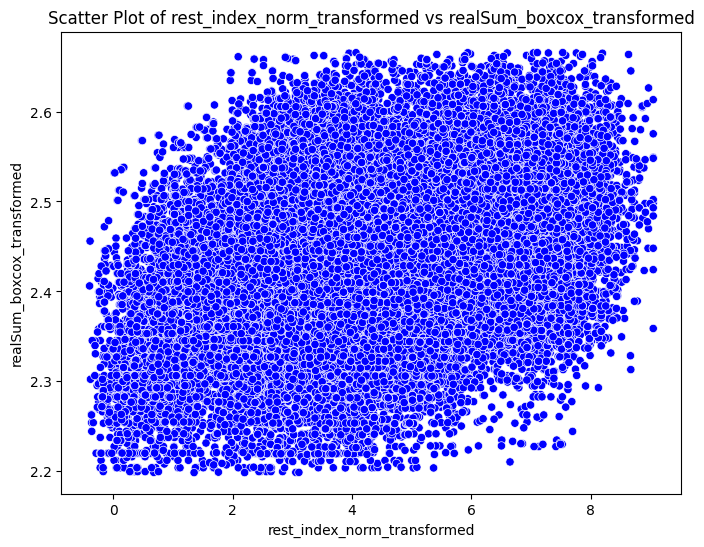

In [25]:
def find_z_outliers(series):
    z_scores = zscore(series)
    return (abs(z_scores) > 3)

    
features = ['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']
target = 'realSum_boxcox_transformed'

for feature in features:
    df['is_outlier'] = find_z_outliers(df[feature])  # Identify outliers in the feature

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df[target], hue=df['is_outlier'], palette=['blue', 'red'], legend=False)
    plt.title(f'Scatter Plot of {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

In [27]:
# Q1 = df[['dist_transformed', 'metro_dist_transformed',
#        'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']].quantile(0.25)
# Q3 = df[['dist_transformed', 'metro_dist_transformed',
#        'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']].quantile(0.75)
# IQR = Q3 - Q1
# outliers_iqr = ((df[['dist_transformed', 'metro_dist_transformed',
#        'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']] < (Q1 - 1.5 * IQR)) | (df[['dist_transformed', 'metro_dist_transformed',
#        'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']] > (Q3 + 1.5 * IQR))).any(axis=1)


In [28]:
# Q1 = df['realSum_boxcox_transformed'].quantile(0.25)
# Q3 = df['realSum_boxcox_transformed'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# lower_bound

# df = df[~((df['realSum_boxcox_transformed'] >= upper_bound) | (df['realSum_boxcox_transformed'] <= lower_bound))]
# df

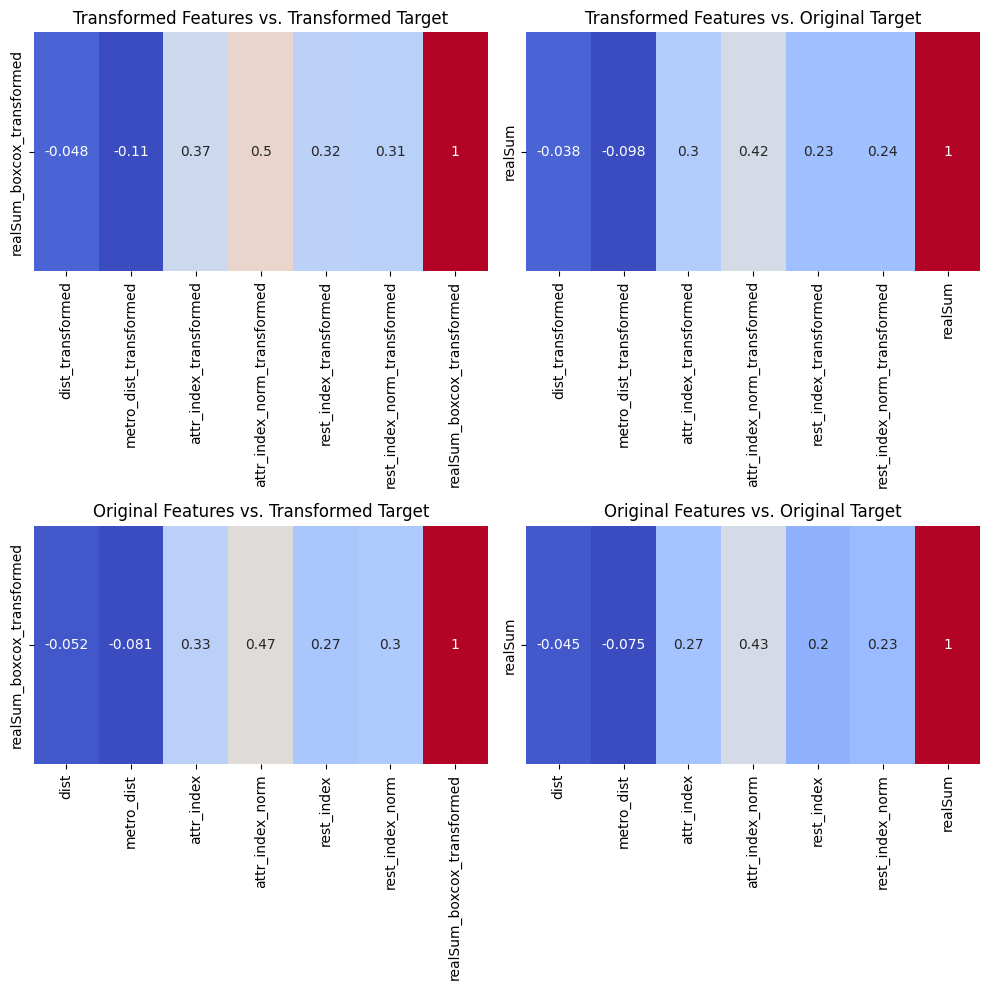

In [26]:
corr_original = df[['dist','metro_dist', 'attr_index', 'attr_index_norm', 'rest_index','rest_index_norm', 'realSum']].corr().loc[['realSum']]

corr_transformed_features = df[['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed',
                               'realSum']].corr().loc[['realSum']]

corr_transformed_target = df[['dist','metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
                              'rest_index_norm', 'realSum_boxcox_transformed']].corr().loc[['realSum_boxcox_transformed']]

corr_both_transformed = df[['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed',
                               'realSum_boxcox_transformed']].corr().loc[['realSum_boxcox_transformed']]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(corr_both_transformed, annot=True, cmap='coolwarm', ax=axes[0, 0], cbar=False)
axes[0, 0].set_title('Transformed Features vs. Transformed Target')

sns.heatmap(corr_transformed_features, annot=True, cmap='coolwarm', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('Transformed Features vs. Original Target')

sns.heatmap(corr_transformed_target, annot=True, cmap='coolwarm', ax=axes[1, 0], cbar=False)
axes[1, 0].set_title('Original Features vs. Transformed Target')

sns.heatmap(corr_original, annot=True, cmap='coolwarm', ax=axes[1, 1], cbar=False)
axes[1, 1].set_title('Original Features vs. Original Target')

plt.tight_layout()
plt.show()

### Can see correlations against the target are highest when both features and target is transformed.

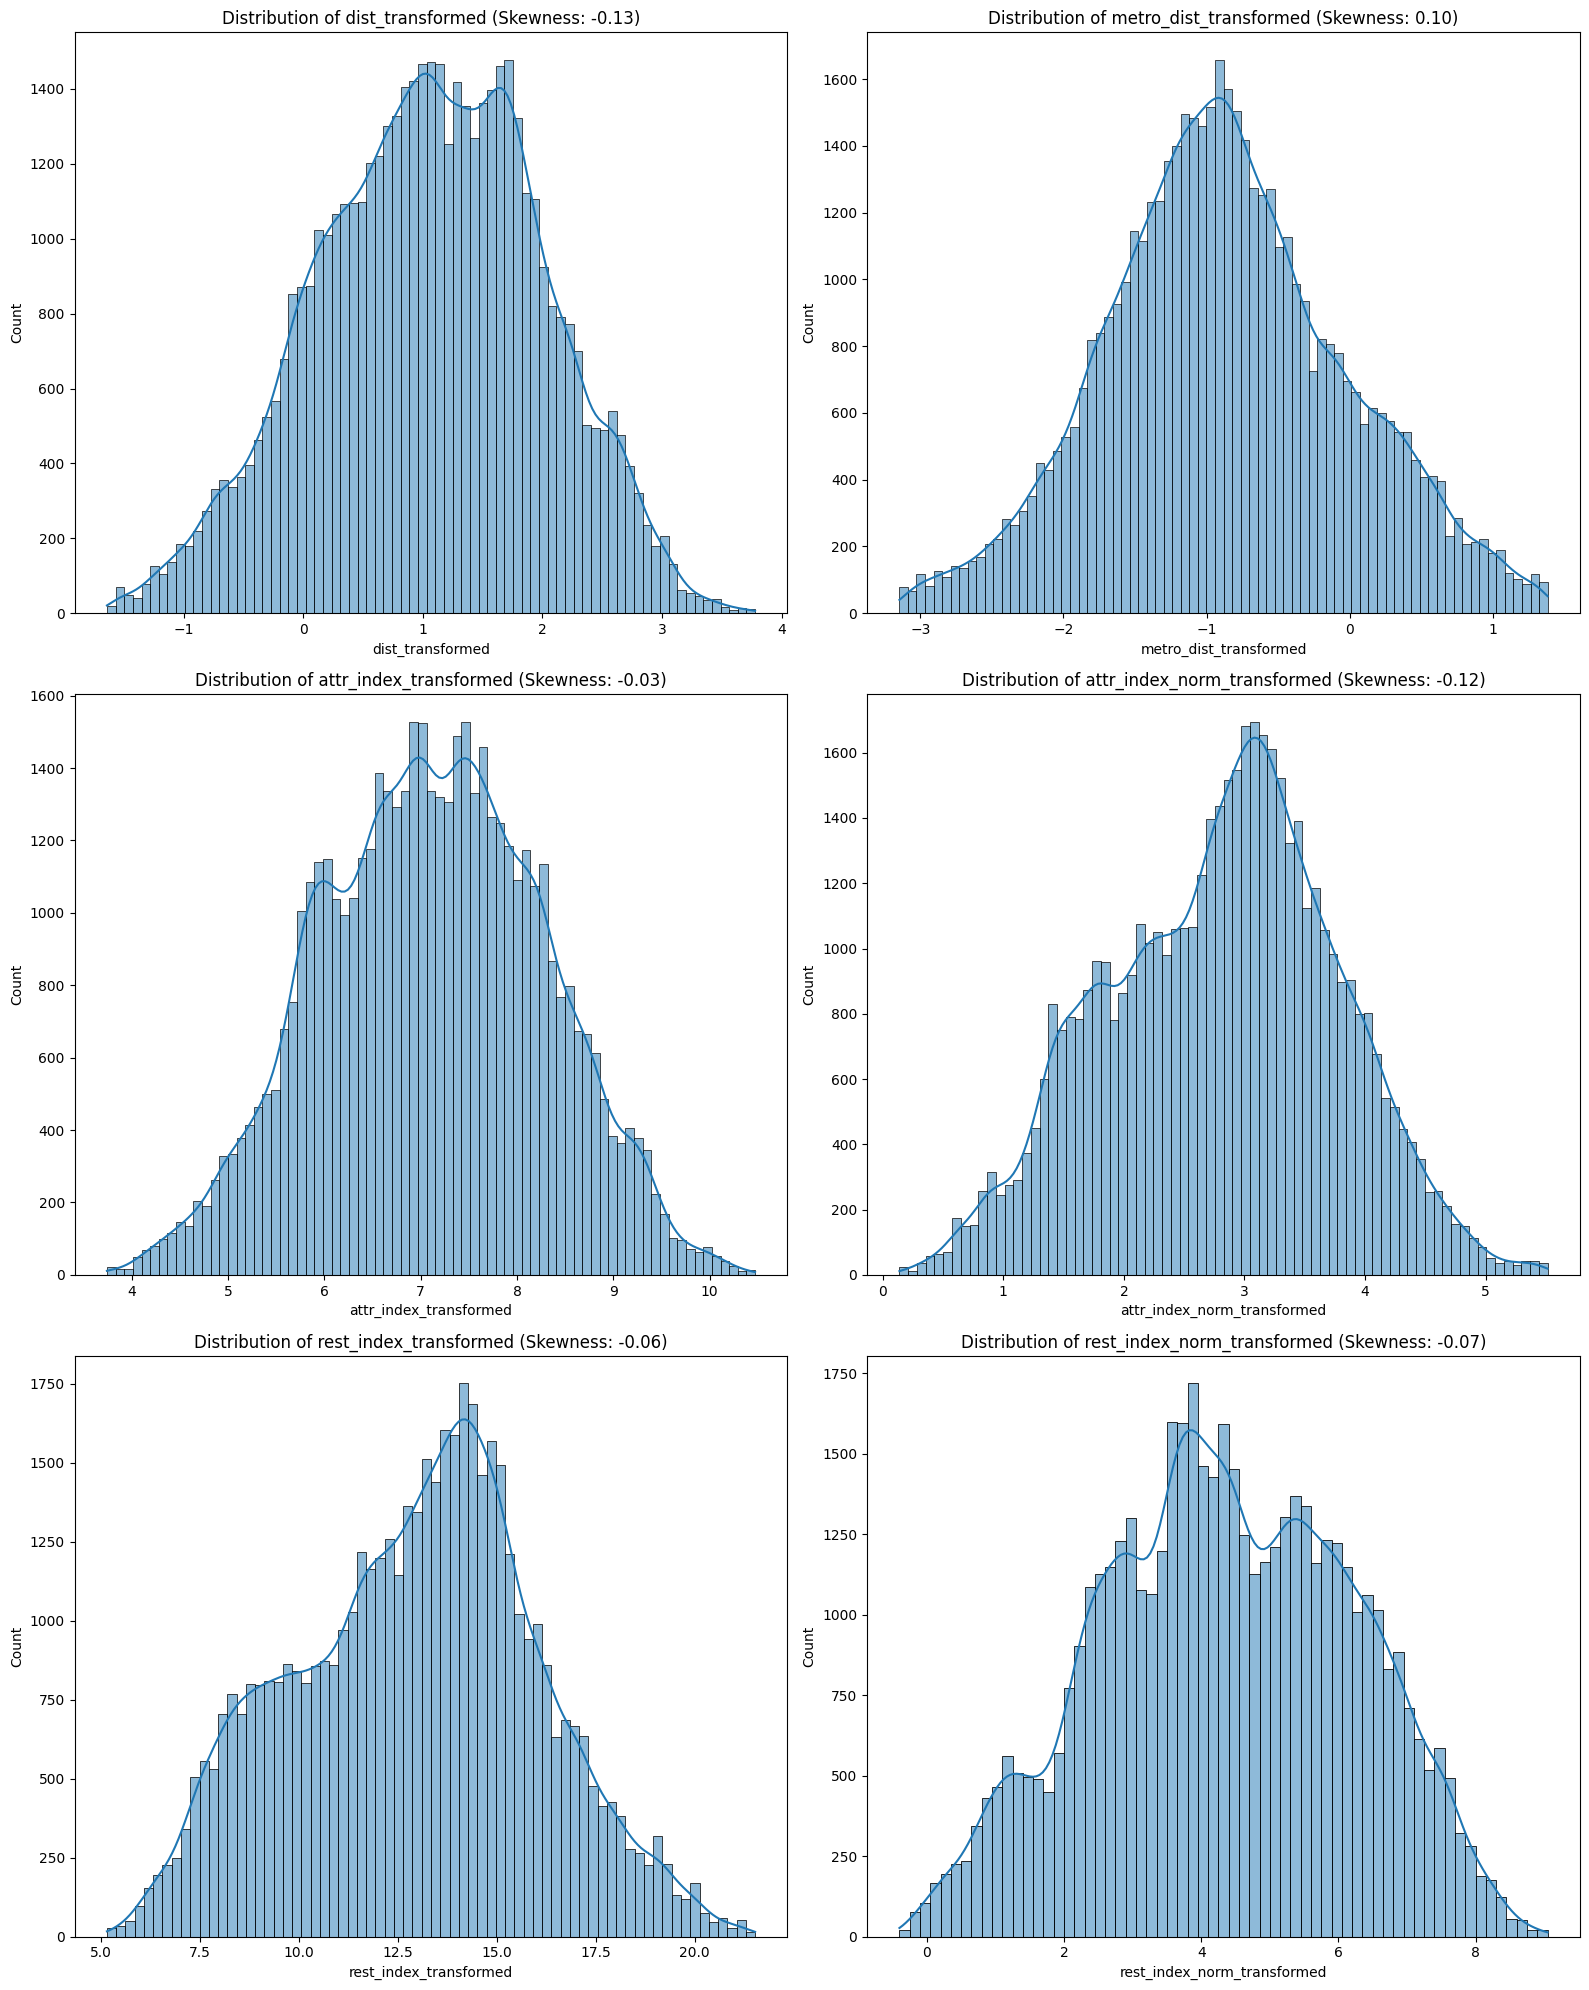

dist_transformed              -0.126222
metro_dist_transformed         0.102649
attr_index_transformed        -0.033670
attr_index_norm_transformed   -0.117087
rest_index_transformed        -0.056945
rest_index_norm_transformed   -0.073907
dtype: float64


In [27]:
continuous_transformed = df[['dist_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'attr_index_norm_transformed', 'rest_index_transformed', 'rest_index_norm_transformed']]
plot_histograms(continuous_transformed)

In [33]:
df = df.drop('is_outlier', axis=1)

In [34]:
df.reset_index(inplace=True, drop=True)

In [35]:
df

realSum        room_type  room_shared  room_private  \
0      194.033698     Private room        False          True   
1      344.245776     Private room        False          True   
2      264.101422     Private room        False          True   
3      433.529398     Private room        False          True   
4      485.552926     Private room        False          True   
...           ...              ...          ...           ...   
49574  715.938574  Entire home/apt        False         False   
49575  304.793960  Entire home/apt        False         False   
49576  637.168969  Entire home/apt        False         False   
49577  301.054157     Private room        False          True   
49578  133.230489     Private room        False          True   

       person_capacity  host_is_superhost  multi    biz  cleanliness_rating  \
0                  2.0              False   True  False                10.0   
1                  4.0              False  False  False                 8.0   
2                  2.0              False  False   True                 9.0   
3                  4.0              False  False   True                 9.0   
4                  2.0               True  False  False                10.0   
...                ...                ...    ...    ...                 ...   
49574              6.0              False  False   True                10.0   
49575              2.0              False  False  False                 8.0   
49576              2.0              False  False  False                10.0   
49577              2.0              False  False  False                10.0   
49578              4.0               True   True  False                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                            93.0         1  5.022964    2.539380   78.690379   
1                            85.0         1  0.488389    0.239404  631.176378   
2                            87.0         1  5.748312    3.651621   75.275877   
3                            90.0         2  0.384862    0.439876  493.272534   
4                            98.0         1  0.544738    0.318693  552.830324   
...                           ...       ...       ...         ...         ...   
49574                       100.0         3  0.530181    0.135447  219.402478   
49575                        86.0         1  0.810205    0.100839  204.970121   
49576                        93.0         1  0.994051    0.202539  169.073402   
49577                        87.0         1  3.044100    0.287435  109.236574   
49578                        93.0         1  1.263932    0.480903  150.450381   

       attr_index_norm  rest_index  rest_index_norm       lng       lat  \
0             4.166708   98.253896         6.846473   4.90569  52.41772   
1            33.421209  837.280757        58.342928   4.90005  52.37432   
2             3.985908   95.386955         6.646700   4.97512  52.36103   
3            26.119108  875.033098        60.973565   4.89417  52.37663   
4            29.272733  815.305740        56.811677   4.90051  52.37508   
...                ...         ...              ...       ...       ...   
49574        15.712158  438.756874        10.604584  16.37940  48.21136   
49575        14.678608  342.182813         8.270427  16.38070  48.20296   
49576        12.107921  282.296424         6.822996  16.38568  48.20460   
49577         7.822803  158.563398         3.832416  16.34100  48.19200   
49578        10.774264  225.247293         5.444140  16.39066  48.20811   

            city day_of_week  realSum_boxcox_transformed  dist_transformed  \
0      amsterdam    weekdays                    2.417335          1.990728   
1      amsterdam    weekdays                    2.500767         -0.655784   
2      amsterdam    weekdays                    2.464258          2.196604   
3      amsterdam    weekdays                    2.529912         -0.848888   
4      amsterdam

### Now that we are done with continuous variables, let's move onto other variables

In [36]:
df[['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz']] = df[['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz']].astype(int)

# non_continuous = df[['room_type', 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 
#                      'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'lng', 'lat', 'city', 'day_of_week']]
# non_continuous.head()


In [37]:
# non_continuous['room_type'].unique()

In [38]:
df

realSum        room_type  room_shared  room_private  \
0      194.033698     Private room            0             1   
1      344.245776     Private room            0             1   
2      264.101422     Private room            0             1   
3      433.529398     Private room            0             1   
4      485.552926     Private room            0             1   
...           ...              ...          ...           ...   
49574  715.938574  Entire home/apt            0             0   
49575  304.793960  Entire home/apt            0             0   
49576  637.168969  Entire home/apt            0             0   
49577  301.054157     Private room            0             1   
49578  133.230489     Private room            0             1   

       person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                  2.0                  0      1    0                10.0   
1                  4.0                  0      0    0                 8.0   
2                  2.0                  0      0    1                 9.0   
3                  4.0                  0      0    1                 9.0   
4                  2.0                  1      0    0                10.0   
...                ...                ...    ...  ...                 ...   
49574              6.0                  0      0    1                10.0   
49575              2.0                  0      0    0                 8.0   
49576              2.0                  0      0    0                10.0   
49577              2.0                  0      0    0                10.0   
49578              4.0                  1      1    0                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                            93.0         1  5.022964    2.539380   78.690379   
1                            85.0         1  0.488389    0.239404  631.176378   
2                            87.0         1  5.748312    3.651621   75.275877   
3                            90.0         2  0.384862    0.439876  493.272534   
4                            98.0         1  0.544738    0.318693  552.830324   
...                           ...       ...       ...         ...         ...   
49574                       100.0         3  0.530181    0.135447  219.402478   
49575                        86.0         1  0.810205    0.100839  204.970121   
49576                        93.0         1  0.994051    0.202539  169.073402   
49577                        87.0         1  3.044100    0.287435  109.236574   
49578                        93.0         1  1.263932    0.480903  150.450381   

       attr_index_norm  rest_index  rest_index_norm       lng       lat  \
0             4.166708   98.253896         6.846473   4.90569  52.41772   
1            33.421209  837.280757        58.342928   4.90005  52.37432   
2             3.985908   95.386955         6.646700   4.97512  52.36103   
3            26.119108  875.033098        60.973565   4.89417  52.37663   
4            29.272733  815.305740        56.811677   4.90051  52.37508   
...                ...         ...              ...       ...       ...   
49574        15.712158  438.756874        10.604584  16.37940  48.21136   
49575        14.678608  342.182813         8.270427  16.38070  48.20296   
49576        12.107921  282.296424         6.822996  16.38568  48.20460   
49577         7.822803  158.563398         3.832416  16.34100  48.19200   
49578        10.774264  225.247293         5.444140  16.39066  48.20811   

            city day_of_week  realSum_boxcox_transformed  dist_transformed  \
0      amsterdam    weekdays                    2.417335          1.990728   
1      amsterdam    weekdays                    2.500767         -0.655784   
2      amsterdam    weekdays                    2.464258          2.196604   
3      amsterdam    weekdays                    2.529912         -0.848888   
4      amsterdam    weekdays            

In [39]:
df[df['room_type'] == df['room_type'].unique()[0]].head()

Q1 = df[df['room_type'] == 'Private room']['realSum_boxcox_transformed'].quantile(0.25)
Q3 = df[df['room_type'] == 'Private room']['realSum_boxcox_transformed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.8 * IQR
upper_bound = Q3 + 1.8 * IQR



/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/2038513776.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/2038513776.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/2038513776.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/2038513776.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

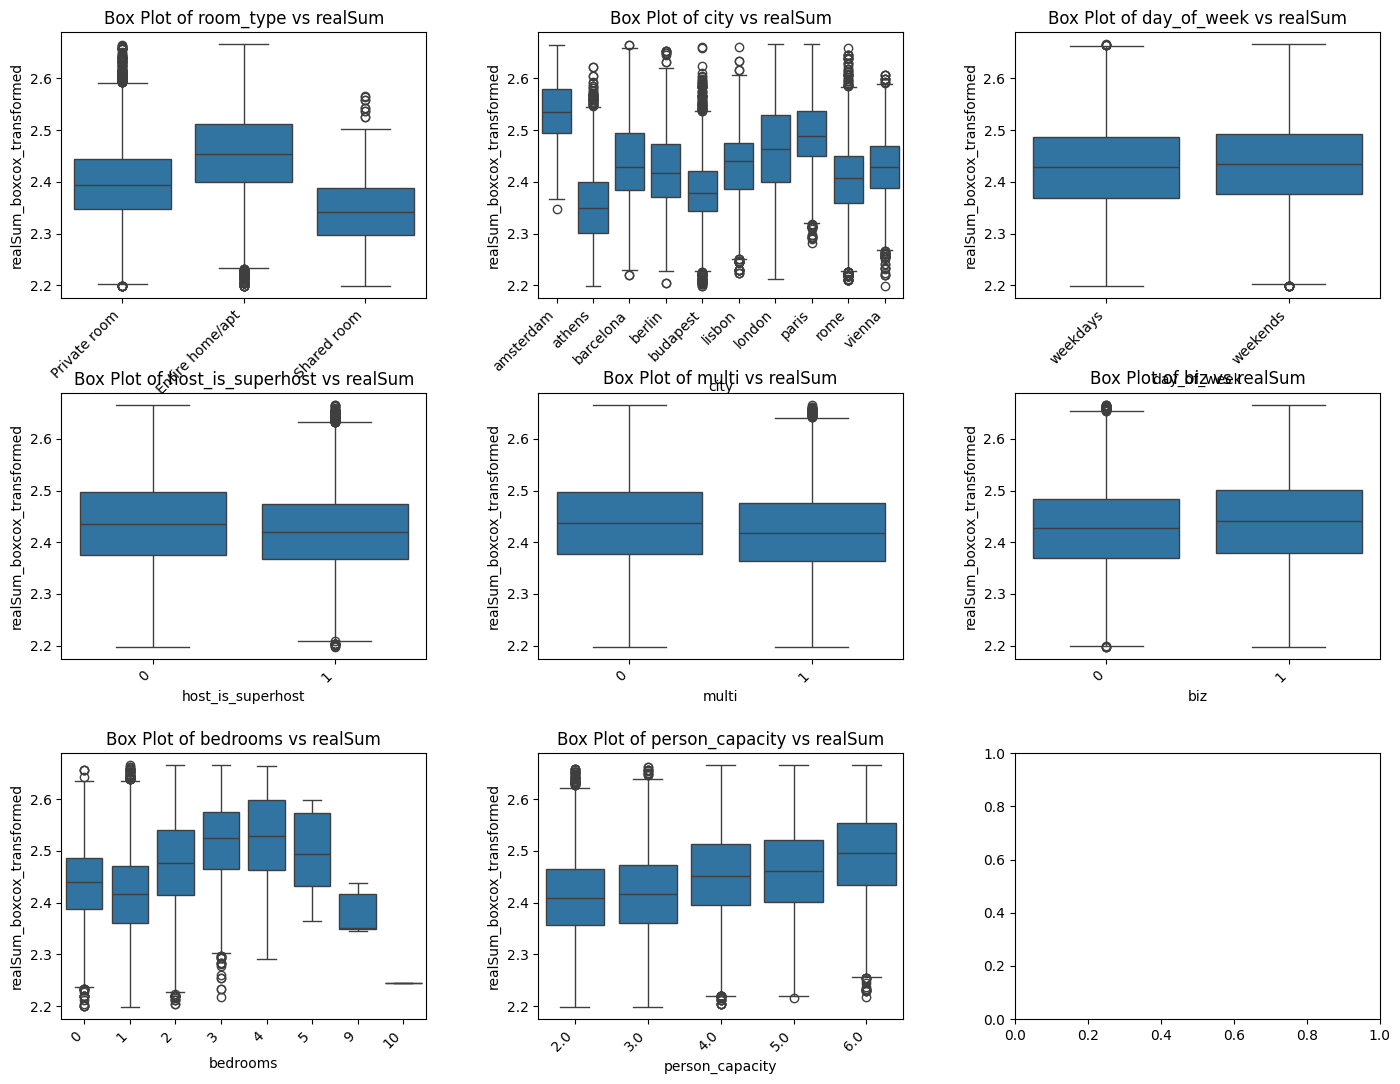

In [41]:
categorical_cols = ['room_type', 'city', 'day_of_week', 'host_is_superhost', 'multi', 'biz', 'bedrooms', 'person_capacity']

n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
fig.tight_layout(pad=5.0)

for i, col in enumerate(categorical_cols):
    ax = axes[i//n_cols, i%n_cols]
    sns.boxplot(x=col, y='realSum_boxcox_transformed', data=df, ax=ax)
    ax.set_title(f'Box Plot of {col} vs realSum')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.subplots_adjust(top=0.9)
plt.show()


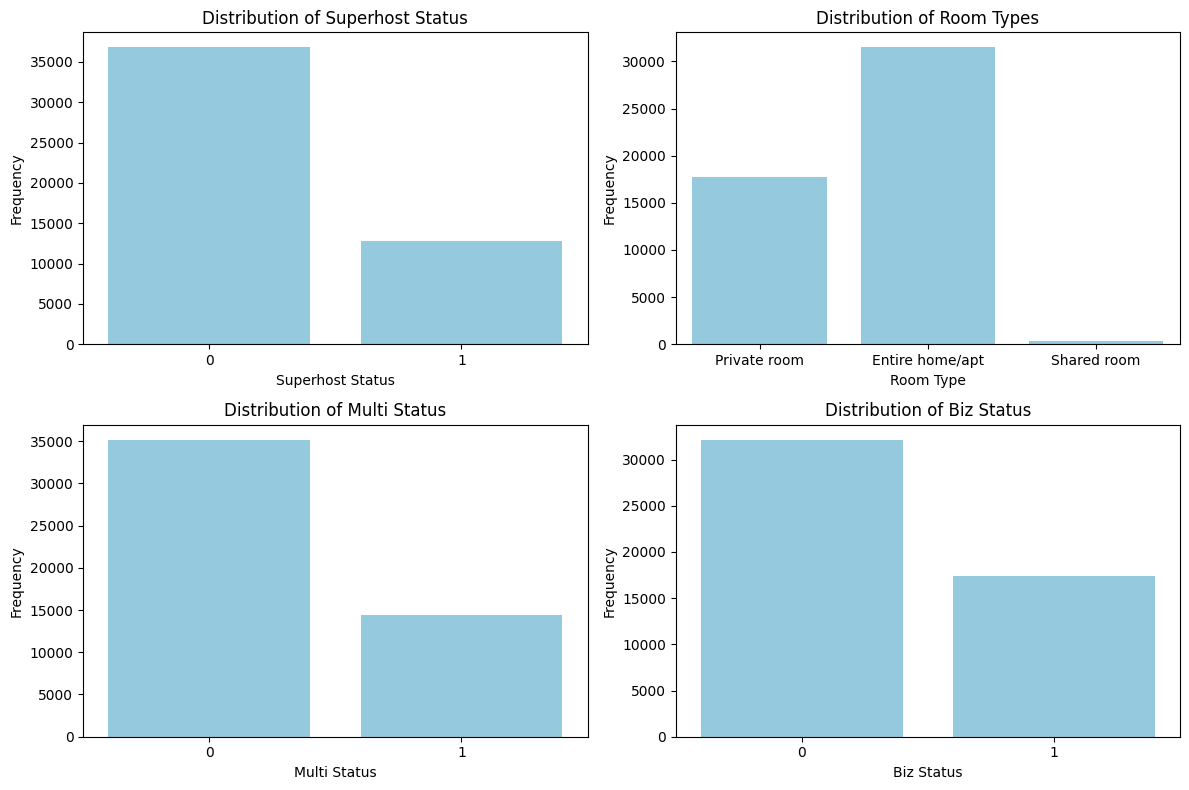

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

sns.countplot(x='host_is_superhost', color='skyblue', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Superhost Status')
axes[0, 0].set_xlabel('Superhost Status')
axes[0, 0].set_ylabel('Frequency')

sns.countplot(x='room_type', color='skyblue', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Room Types')
axes[0, 1].set_xlabel('Room Type')
axes[0, 1].set_ylabel('Frequency')

sns.countplot(x='multi', color='skyblue', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Multi Status')
axes[1, 0].set_xlabel('Multi Status')
axes[1, 0].set_ylabel('Frequency')

sns.countplot(x='biz', color='skyblue', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Biz Status')
axes[1, 1].set_xlabel('Biz Status')
axes[1, 1].set_ylabel('Frequency')
plt.tight_layout()

plt.show()


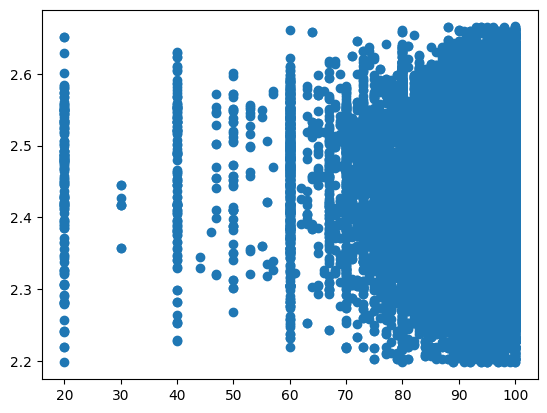

In [46]:
plt.scatter(x = 'guest_satisfaction_overall', y = 'realSum_boxcox_transformed', data = df)

<Axes: xlabel='guest_satisfaction_overall', ylabel='realSum_boxcox_transformed'>

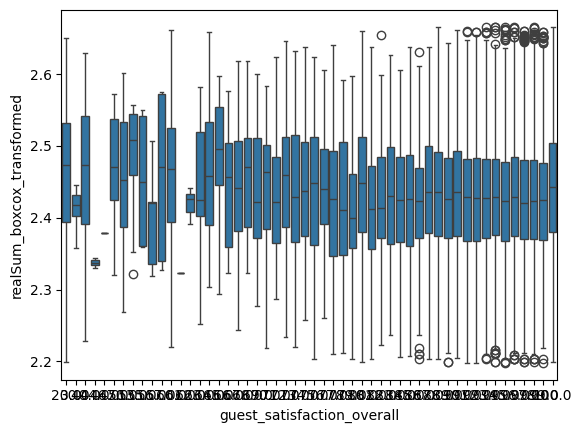

In [47]:
sns.boxplot(x='guest_satisfaction_overall', y='realSum_boxcox_transformed', data=df)


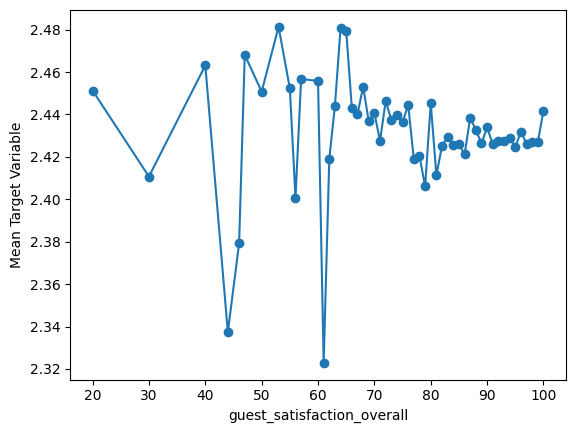

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

means = df.groupby('guest_satisfaction_overall')['realSum_boxcox_transformed'].mean().reset_index()
sns.scatterplot(x='guest_satisfaction_overall', y='realSum_boxcox_transformed', data=means)
plt.plot(means['guest_satisfaction_overall'], means['realSum_boxcox_transformed'], marker='o')
plt.xlabel('guest_satisfaction_overall')
plt.ylabel('Mean Target Variable')
plt.show()

In [49]:
df['guest_satisfied'] = pd.qcut(df['guest_satisfaction_overall'], q=2, labels=[0,1])
df

realSum        room_type  room_shared  room_private  \
0      194.033698     Private room            0             1   
1      344.245776     Private room            0             1   
2      264.101422     Private room            0             1   
3      433.529398     Private room            0             1   
4      485.552926     Private room            0             1   
...           ...              ...          ...           ...   
49574  715.938574  Entire home/apt            0             0   
49575  304.793960  Entire home/apt            0             0   
49576  637.168969  Entire home/apt            0             0   
49577  301.054157     Private room            0             1   
49578  133.230489     Private room            0             1   

       person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                  2.0                  0      1    0                10.0   
1                  4.0                  0      0    0                 8.0   
2                  2.0                  0      0    1                 9.0   
3                  4.0                  0      0    1                 9.0   
4                  2.0                  1      0    0                10.0   
...                ...                ...    ...  ...                 ...   
49574              6.0                  0      0    1                10.0   
49575              2.0                  0      0    0                 8.0   
49576              2.0                  0      0    0                10.0   
49577              2.0                  0      0    0                10.0   
49578              4.0                  1      1    0                10.0   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                            93.0         1  5.022964    2.539380   78.690379   
1                            85.0         1  0.488389    0.239404  631.176378   
2                            87.0         1  5.748312    3.651621   75.275877   
3                            90.0         2  0.384862    0.439876  493.272534   
4                            98.0         1  0.544738    0.318693  552.830324   
...                           ...       ...       ...         ...         ...   
49574                       100.0         3  0.530181    0.135447  219.402478   
49575                        86.0         1  0.810205    0.100839  204.970121   
49576                        93.0         1  0.994051    0.202539  169.073402   
49577                        87.0         1  3.044100    0.287435  109.236574   
49578                        93.0         1  1.263932    0.480903  150.450381   

       attr_index_norm  rest_index  rest_index_norm       lng       lat  \
0             4.166708   98.253896         6.846473   4.90569  52.41772   
1            33.421209  837.280757        58.342928   4.90005  52.37432   
2             3.985908   95.386955         6.646700   4.97512  52.36103   
3            26.119108  875.033098        60.973565   4.89417  52.37663   
4            29.272733  815.305740        56.811677   4.90051  52.37508   
...                ...         ...              ...       ...       ...   
49574        15.712158  438.756874        10.604584  16.37940  48.21136   
49575        14.678608  342.182813         8.270427  16.38070  48.20296   
49576        12.107921  282.296424         6.822996  16.38568  48.20460   
49577         7.822803  158.563398         3.832416  16.34100  48.19200   
49578        10.774264  225.247293         5.444140  16.39066  48.20811   

            city day_of_week  realSum_boxcox_transformed  dist_transformed  \
0      amsterdam    weekdays                    2.417335          1.990728   
1      amsterdam    weekdays                    2.500767         -0.655784   
2      amsterdam    weekdays                    2.464258          2.196604   
3      amsterdam    weekdays                    2.529912         -0.848888   
4      amsterdam    weekdays            

<Axes: xlabel='guest_satisfied', ylabel='realSum_boxcox_transformed'>

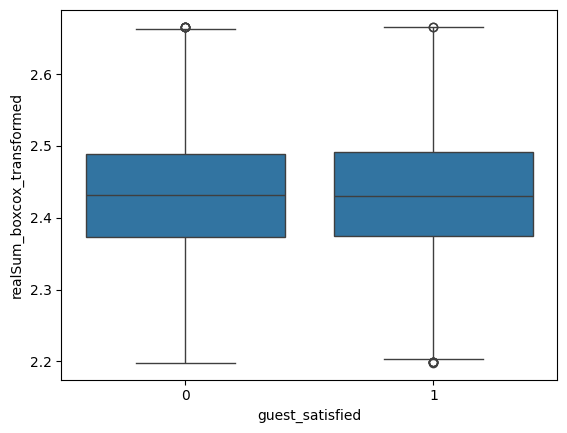

In [50]:
sns.boxplot(x='guest_satisfied', y='realSum_boxcox_transformed', data=df)


/var/folders/k9/skl70t5x6j5bsp12t3thym9c0000gn/T/ipykernel_34288/2158675933.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('guest_satisfied')['realSum_boxcox_transformed'].mean().reset_index()


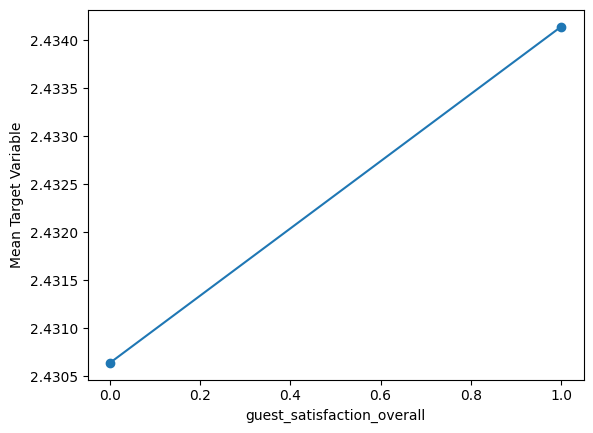

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

means = df.groupby('guest_satisfied')['realSum_boxcox_transformed'].mean().reset_index()
sns.scatterplot(x='guest_satisfied', y='realSum_boxcox_transformed', data=means)
plt.plot(means['guest_satisfied'], means['realSum_boxcox_transformed'], marker='o')
plt.xlabel('guest_satisfaction_overall')
plt.ylabel('Mean Target Variable')
plt.show()

<Axes: xlabel='cleanliness_rating', ylabel='realSum_boxcox_transformed'>

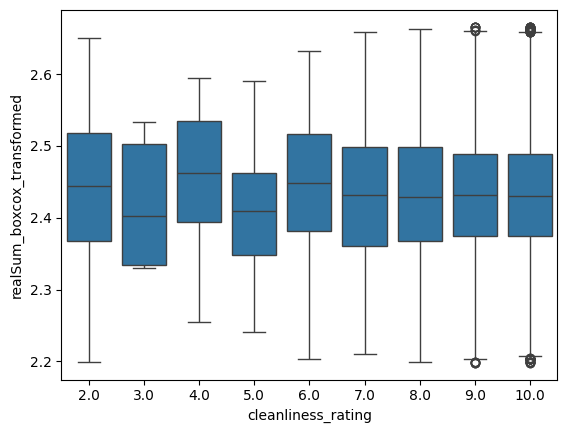

In [52]:
sns.boxplot(x='cleanliness_rating', y='realSum_boxcox_transformed', data=df)


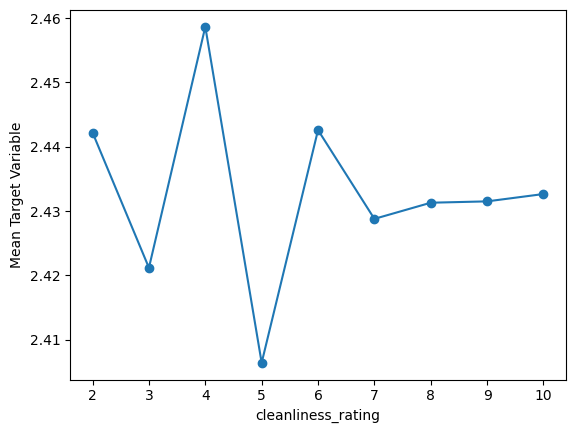

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

means = df.groupby('cleanliness_rating')['realSum_boxcox_transformed'].mean().reset_index()
sns.scatterplot(x='cleanliness_rating', y='realSum_boxcox_transformed', data=means)
plt.plot(means['cleanliness_rating'], means['realSum_boxcox_transformed'], marker='o')
plt.xlabel('cleanliness_rating')
plt.ylabel('Mean Target Variable')
plt.show()

In [54]:
df = df.drop('guest_satisfaction_overall', axis = 1)

### We can remove room_type as there are already boolean columns that represent them

In [55]:
df = df.drop('room_type', axis = 1)
df.head()

realSum  room_shared  room_private  person_capacity  host_is_superhost  \
0  194.033698            0             1              2.0                  0   
1  344.245776            0             1              4.0                  0   
2  264.101422            0             1              2.0                  0   
3  433.529398            0             1              4.0                  0   
4  485.552926            0             1              2.0                  1   

   multi  biz  cleanliness_rating  bedrooms      dist  metro_dist  attr_index  \
0      1    0                10.0         1  5.022964    2.539380   78.690379   
1      0    0                 8.0         1  0.488389    0.239404  631.176378   
2      0    1                 9.0         1  5.748312    3.651621   75.275877   
3      0    1                 9.0         2  0.384862    0.439876  493.272534   
4      0    0                10.0         1  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat       city  \
0         4.166708   98.253896         6.846473  4.90569  52.41772  amsterdam   
1        33.421209  837.280757        58.342928  4.90005  52.37432  amsterdam   
2         3.985908   95.386955         6.646700  4.97512  52.36103  amsterdam   
3        26.119108  875.033098        60.973565  4.89417  52.37663  amsterdam   
4        29.272733  815.305740        56.811677  4.90051  52.37508  amsterdam   

  day_of_week  realSum_boxcox_transformed  dist_transformed  \
0    weekdays                    2.417335          1.990728   
1    weekdays                    2.500767         -0.655784   
2    weekdays                    2.464258          2.196604   
3    weekdays                    2.529912         -0.848888   
4    weekdays                    2.543402         -0.563333   

   metro_dist_transformed  attr_index_transformed  \
0                0.908426                5.380384   
1               -1.487343                8.821467   
2                1.250092                5.314048   
3               -0.840104                8.378551   
4               -1.180276                8.582092   

   attr_index_norm_transformed  rest_index_transformed  \
0                     1.571661                7.801768   
1                     4.472621               15.061885   
2                     1.518178                7.722939   
3                     4.085734               15.249095   
4                     4.263048               14.949837   

   rest_index_norm_transformed guest_satisfied  
0                     2.513126               0  
1                     7.337741               0  
2                     2.463874               0  
3                     7.468852               0  
4                     7.259414               1

In [56]:
df = pd.get_dummies(df, columns = ['day_of_week'] ,dtype = int, drop_first=True)
df.head()

realSum  room_shared  room_private  person_capacity  host_is_superhost  \
0  194.033698            0             1              2.0                  0   
1  344.245776            0             1              4.0                  0   
2  264.101422            0             1              2.0                  0   
3  433.529398            0             1              4.0                  0   
4  485.552926            0             1              2.0                  1   

   multi  biz  cleanliness_rating  bedrooms      dist  metro_dist  attr_index  \
0      1    0                10.0         1  5.022964    2.539380   78.690379   
1      0    0                 8.0         1  0.488389    0.239404  631.176378   
2      0    1                 9.0         1  5.748312    3.651621   75.275877   
3      0    1                 9.0         2  0.384862    0.439876  493.272534   
4      0    0                10.0         1  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat       city  \
0         4.166708   98.253896         6.846473  4.90569  52.41772  amsterdam   
1        33.421209  837.280757        58.342928  4.90005  52.37432  amsterdam   
2         3.985908   95.386955         6.646700  4.97512  52.36103  amsterdam   
3        26.119108  875.033098        60.973565  4.89417  52.37663  amsterdam   
4        29.272733  815.305740        56.811677  4.90051  52.37508  amsterdam   

   realSum_boxcox_transformed  dist_transformed  metro_dist_transformed  \
0                    2.417335          1.990728                0.908426   
1                    2.500767         -0.655784               -1.487343   
2                    2.464258          2.196604                1.250092   
3                    2.529912         -0.848888               -0.840104   
4                    2.543402         -0.563333               -1.180276   

   attr_index_transformed  attr_index_norm_transformed  \
0                5.380384                     1.571661   
1                8.821467                     4.472621   
2                5.314048                     1.518178   
3                8.378551                     4.085734   
4                8.582092                     4.263048   

   rest_index_transformed  rest_index_norm_transformed guest_satisfied  \
0                7.801768                     2.513126               0   
1               15.061885                     7.337741               0   
2                7.722939                     2.463874               0   
3               15.249095                     7.468852               0   
4               14.949837                     7.259414               1   

   day_of_week_weekends  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [57]:
df

realSum  room_shared  room_private  person_capacity  \
0      194.033698            0             1              2.0   
1      344.245776            0             1              4.0   
2      264.101422            0             1              2.0   
3      433.529398            0             1              4.0   
4      485.552926            0             1              2.0   
...           ...          ...           ...              ...   
49574  715.938574            0             0              6.0   
49575  304.793960            0             0              2.0   
49576  637.168969            0             0              2.0   
49577  301.054157            0             1              2.0   
49578  133.230489            0             1              4.0   

       host_is_superhost  multi  biz  cleanliness_rating  bedrooms      dist  \
0                      0      1    0                10.0         1  5.022964   
1                      0      0    0                 8.0         1  0.488389   
2                      0      0    1                 9.0         1  5.748312   
3                      0      0    1                 9.0         2  0.384862   
4                      1      0    0                10.0         1  0.544738   
...                  ...    ...  ...                 ...       ...       ...   
49574                  0      0    1                10.0         3  0.530181   
49575                  0      0    0                 8.0         1  0.810205   
49576                  0      0    0                10.0         1  0.994051   
49577                  0      0    0                10.0         1  3.044100   
49578                  1      1    0                10.0         1  1.263932   

       metro_dist  attr_index  attr_index_norm  rest_index  rest_index_norm  \
0        2.539380   78.690379         4.166708   98.253896         6.846473   
1        0.239404  631.176378        33.421209  837.280757        58.342928   
2        3.651621   75.275877         3.985908   95.386955         6.646700   
3        0.439876  493.272534        26.119108  875.033098        60.973565   
4        0.318693  552.830324        29.272733  815.305740        56.811677   
...           ...         ...              ...         ...              ...   
49574    0.135447  219.402478        15.712158  438.756874        10.604584   
49575    0.100839  204.970121        14.678608  342.182813         8.270427   
49576    0.202539  169.073402        12.107921  282.296424         6.822996   
49577    0.287435  109.236574         7.822803  158.563398         3.832416   
49578    0.480903  150.450381        10.774264  225.247293         5.444140   

            lng       lat       city  realSum_boxcox_transformed  \
0       4.90569  52.41772  amsterdam                    2.417335   
1       4.90005  52.37432  amsterdam                    2.500767   
2       4.97512  52.36103  amsterdam                    2.464258   
3       4.89417  52.37663  amsterdam                    2.529912   
4       4.90051  52.37508  amsterdam                    2.543402   
...         ...       ...        ...                         ...   
49574  16.37940  48.21136     vienna                    2.585798   
49575  16.38070  48.20296     vienna                    2.484416   
49576  16.38568  48.20460     vienna                    2.573667   
49577  16.34100  48.19200     vienna                    2.482718   
49578  16.39066  48.20811     vienna                    2.352882   

       dist_transformed  metro_dist_transformed  attr_index_transformed  \
0              1.990728                0.908426                5.380384   
1             -0.655784               -1.487343                8.821467   
2              2.196604                1.250092                5.314048   
3             -0.848888               -0.840104                8.378551   
4             -0.563333               -1.180276                8.582092   
...                 ...                     ...     

In [58]:
df = pd.get_dummies(df, columns = ['city'] ,dtype = int)

In [59]:
df.head()

realSum  room_shared  room_private  person_capacity  host_is_superhost  \
0  194.033698            0             1              2.0                  0   
1  344.245776            0             1              4.0                  0   
2  264.101422            0             1              2.0                  0   
3  433.529398            0             1              4.0                  0   
4  485.552926            0             1              2.0                  1   

   multi  biz  cleanliness_rating  bedrooms      dist  metro_dist  attr_index  \
0      1    0                10.0         1  5.022964    2.539380   78.690379   
1      0    0                 8.0         1  0.488389    0.239404  631.176378   
2      0    1                 9.0         1  5.748312    3.651621   75.275877   
3      0    1                 9.0         2  0.384862    0.439876  493.272534   
4      0    0                10.0         1  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat  \
0         4.166708   98.253896         6.846473  4.90569  52.41772   
1        33.421209  837.280757        58.342928  4.90005  52.37432   
2         3.985908   95.386955         6.646700  4.97512  52.36103   
3        26.119108  875.033098        60.973565  4.89417  52.37663   
4        29.272733  815.305740        56.811677  4.90051  52.37508   

   realSum_boxcox_transformed  dist_transformed  metro_dist_transformed  \
0                    2.417335          1.990728                0.908426   
1                    2.500767         -0.655784               -1.487343   
2                    2.464258          2.196604                1.250092   
3                    2.529912         -0.848888               -0.840104   
4                    2.543402         -0.563333               -1.180276   

   attr_index_transformed  attr_index_norm_transformed  \
0                5.380384                     1.571661   
1                8.821467                     4.472621   
2                5.314048                     1.518178   
3                8.378551                     4.085734   
4                8.582092                     4.263048   

   rest_index_transformed  rest_index_norm_transformed guest_satisfied  \
0                7.801768                     2.513126               0   
1               15.061885                     7.337741               0   
2                7.722939                     2.463874               0   
3               15.249095                     7.468852               0   
4               14.949837                     7.259414               1   

   day_of_week_weekends  city_amsterdam  city_athens  city_barcelona  \
0                     0               1            0               0   
1                     0               1            0               0   
2                     0               1            0               0   
3                     0               1            0               0   
4                     0               1            0               0   

   city_berlin  city_budapest  city_lisbon  city_london  city_paris  \
0            0              0            0            0           0   
1            0              0            0            0           0   
2            0              0            0            0           0   
3            0              0            0            0           0   
4            0              0            0            0           0   

   city_rome  city_vienna  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0

# remove non-transformed variables

In [60]:
df = df.drop(['realSum', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm'], axis = 1)

In [61]:
df.head()

room_shared  room_private  person_capacity  host_is_superhost  multi  biz  \
0            0             1              2.0                  0      1    0   
1            0             1              4.0                  0      0    0   
2            0             1              2.0                  0      0    1   
3            0             1              4.0                  0      0    1   
4            0             1              2.0                  1      0    0   

   cleanliness_rating  bedrooms      lng       lat  \
0                10.0         1  4.90569  52.41772   
1                 8.0         1  4.90005  52.37432   
2                 9.0         1  4.97512  52.36103   
3                 9.0         2  4.89417  52.37663   
4                10.0         1  4.90051  52.37508   

   realSum_boxcox_transformed  dist_transformed  metro_dist_transformed  \
0                    2.417335          1.990728                0.908426   
1                    2.500767         -0.655784               -1.487343   
2                    2.464258          2.196604                1.250092   
3                    2.529912         -0.848888               -0.840104   
4                    2.543402         -0.563333               -1.180276   

   attr_index_transformed  attr_index_norm_transformed  \
0                5.380384                     1.571661   
1                8.821467                     4.472621   
2                5.314048                     1.518178   
3                8.378551                     4.085734   
4                8.582092                     4.263048   

   rest_index_transformed  rest_index_norm_transformed guest_satisfied  \
0                7.801768                     2.513126               0   
1               15.061885                     7.337741               0   
2                7.722939                     2.463874               0   
3               15.249095                     7.468852               0   
4               14.949837                     7.259414               1   

   day_of_week_weekends  city_amsterdam  city_athens  city_barcelona  \
0                     0               1            0               0   
1                     0               1            0               0   
2                     0               1            0               0   
3                     0               1            0               0   
4                     0               1            0               0   

   city_berlin  city_budapest  city_lisbon  city_london  city_paris  \
0            0              0            0            0           0   
1            0              0            0            0           0   
2            0              0            0            0           0   
3            0              0            0            0           0   
4            0              0            0            0           0   

   city_rome  city_vienna  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0

# get rid of highly correlated and redundant variables. answer why we need to get rid of them

In [62]:
df = df.drop(['attr_index_norm_transformed', 'rest_index_norm_transformed'], axis = 1)

In [63]:
df.head()

room_shared  room_private  person_capacity  host_is_superhost  multi  biz  \
0            0             1              2.0                  0      1    0   
1            0             1              4.0                  0      0    0   
2            0             1              2.0                  0      0    1   
3            0             1              4.0                  0      0    1   
4            0             1              2.0                  1      0    0   

   cleanliness_rating  bedrooms      lng       lat  \
0                10.0         1  4.90569  52.41772   
1                 8.0         1  4.90005  52.37432   
2                 9.0         1  4.97512  52.36103   
3                 9.0         2  4.89417  52.37663   
4                10.0         1  4.90051  52.37508   

   realSum_boxcox_transformed  dist_transformed  metro_dist_transformed  \
0                    2.417335          1.990728                0.908426   
1                    2.500767         -0.655784               -1.487343   
2                    2.464258          2.196604                1.250092   
3                    2.529912         -0.848888               -0.840104   
4                    2.543402         -0.563333               -1.180276   

   attr_index_transformed  rest_index_transformed guest_satisfied  \
0                5.380384                7.801768               0   
1                8.821467               15.061885               0   
2                5.314048                7.722939               0   
3                8.378551               15.249095               0   
4                8.582092               14.949837               1   

   day_of_week_weekends  city_amsterdam  city_athens  city_barcelona  \
0                     0               1            0               0   
1                     0               1            0               0   
2                     0               1            0               0   
3                     0               1            0               0   
4                     0               1            0               0   

   city_berlin  city_budapest  city_lisbon  city_london  city_paris  \
0            0              0            0            0           0   
1            0              0            0            0           0   
2            0              0            0            0           0   
3            0              0            0            0           0   
4            0              0            0            0           0   

   city_rome  city_vienna  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0

<Axes: >

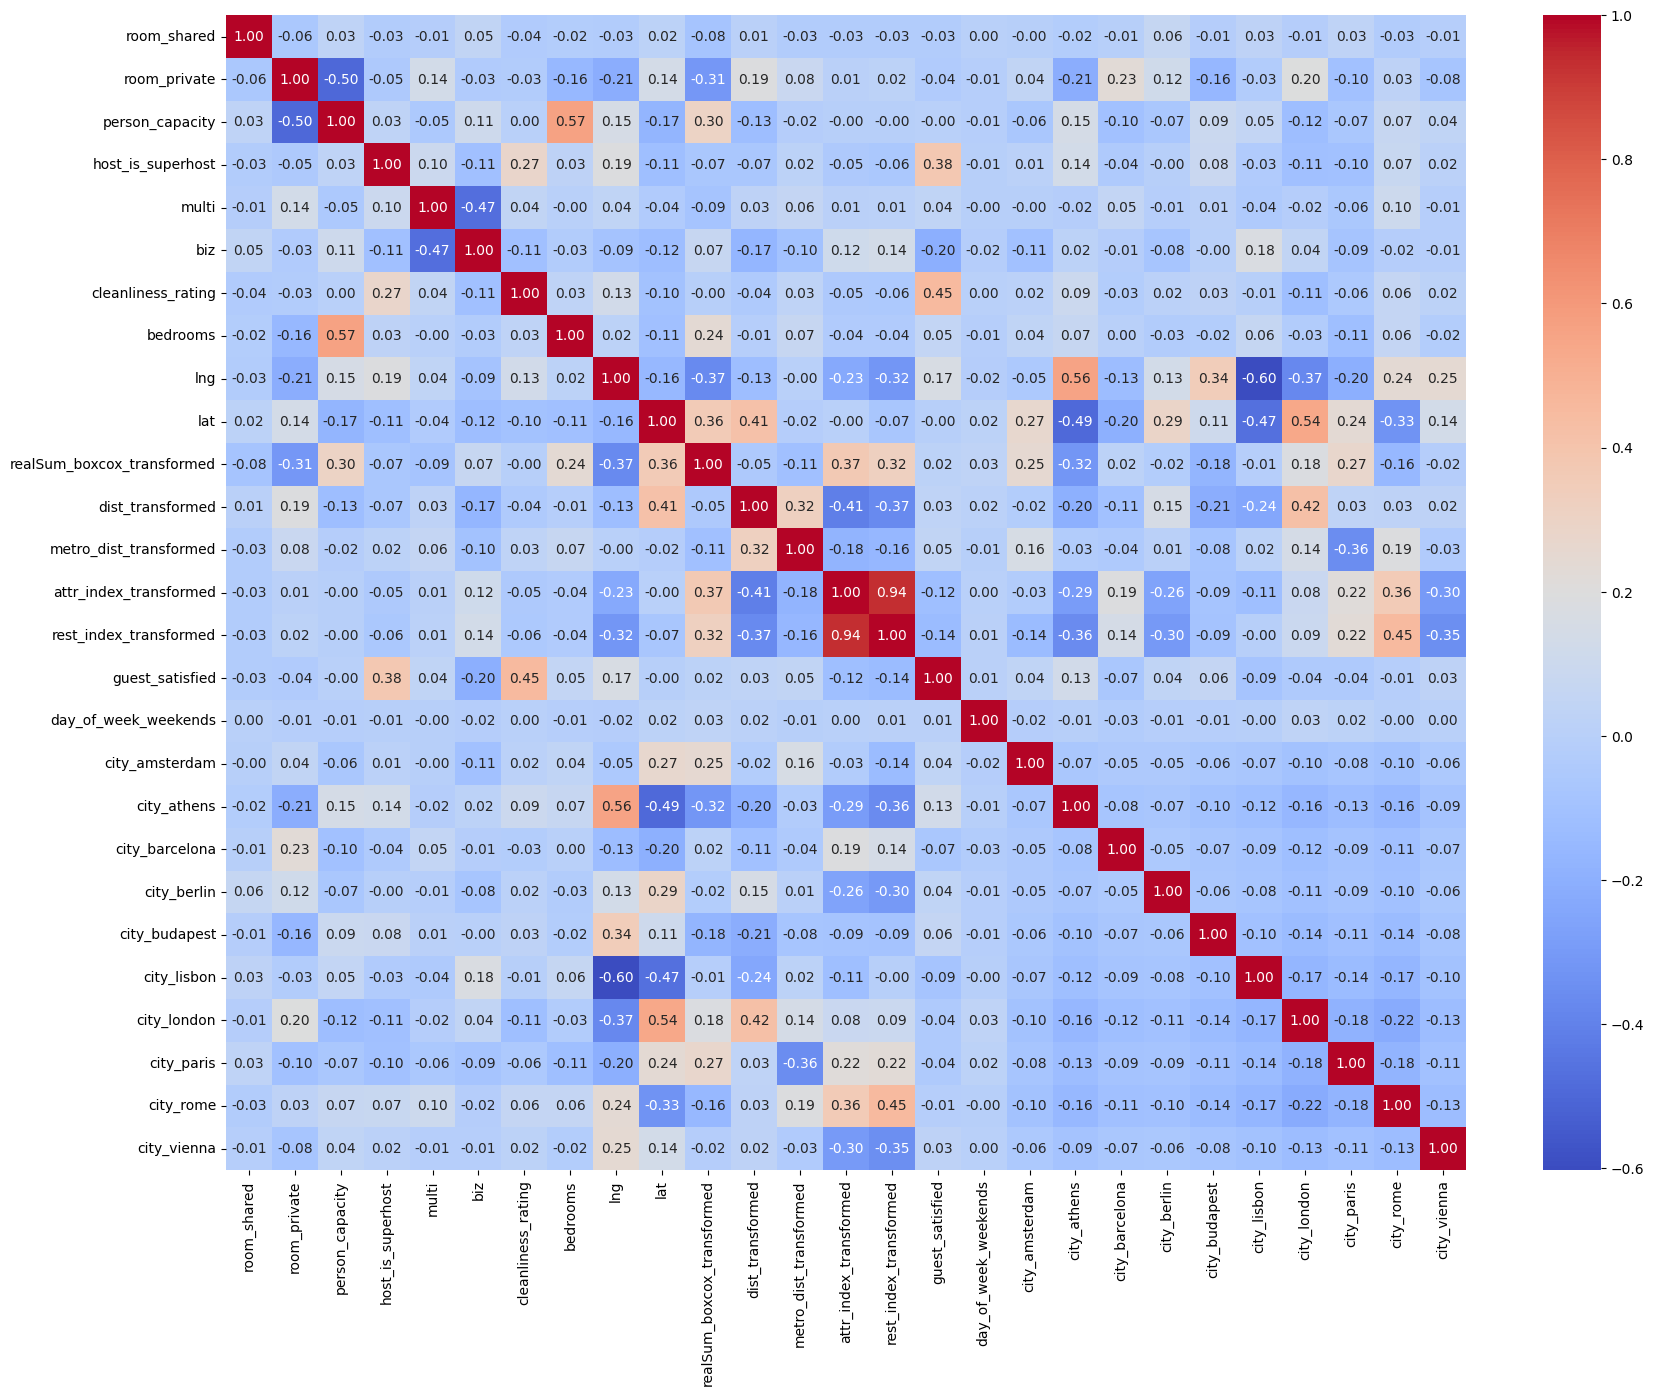

In [64]:
plt.figure(figsize=(20,15))

sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')

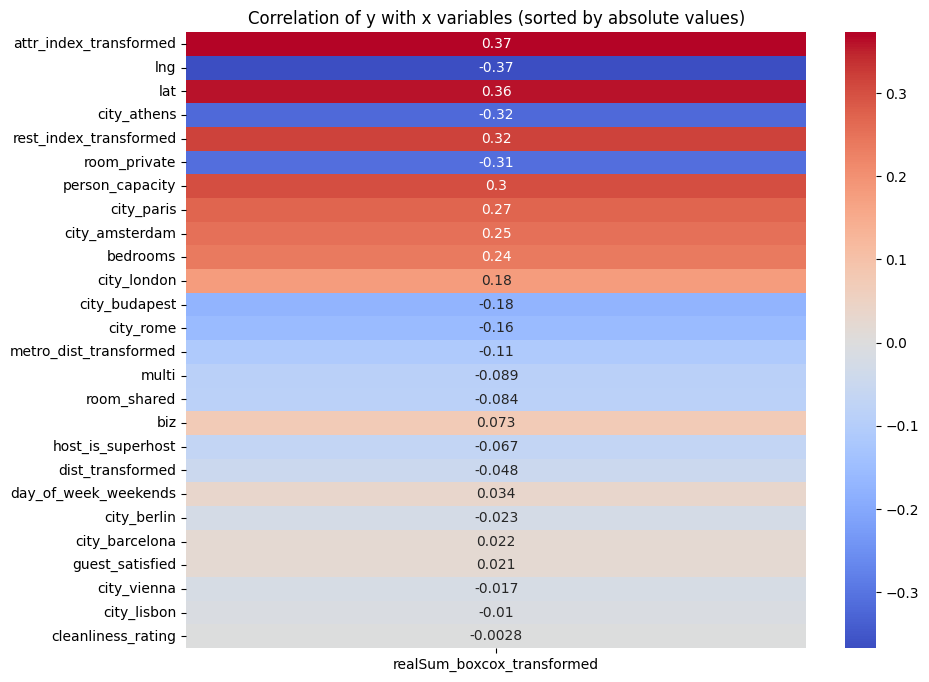

In [65]:
correlation_matrix = df.corr()[['realSum_boxcox_transformed']].drop('realSum_boxcox_transformed')

correlation_matrix['abs_y'] = correlation_matrix['realSum_boxcox_transformed'].abs()
correlation_matrix = correlation_matrix.sort_values(by='abs_y', ascending=False).drop('abs_y', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of y with x variables (sorted by absolute values)')
plt.show()


In [66]:
df.corr()['realSum_boxcox_transformed']
df.corr()['realSum_boxcox_transformed'][df.corr()['realSum_boxcox_transformed'].abs() > 0.1].index

Index(['room_private', 'person_capacity', 'bedrooms', 'lng', 'lat',
       'realSum_boxcox_transformed', 'metro_dist_transformed',
       'attr_index_transformed', 'rest_index_transformed', 'city_amsterdam',
       'city_athens', 'city_budapest', 'city_london', 'city_paris',
       'city_rome'],
      dtype='object')

### drop cleanliness_rating as we even saw through visualizations that it is not linear at all and now uncorrelated

In [67]:
df = df.drop('cleanliness_rating', axis=1)

### get rid of one city to avoid multicollinearity. get rid of lowest correlated city

In [68]:
df = df.drop('city_lisbon', axis=1)

In [69]:
df

room_shared  room_private  person_capacity  host_is_superhost  multi  \
0                0             1              2.0                  0      1   
1                0             1              4.0                  0      0   
2                0             1              2.0                  0      0   
3                0             1              4.0                  0      0   
4                0             1              2.0                  1      0   
...            ...           ...              ...                ...    ...   
49574            0             0              6.0                  0      0   
49575            0             0              2.0                  0      0   
49576            0             0              2.0                  0      0   
49577            0             1              2.0                  0      0   
49578            0             1              4.0                  1      1   

       biz  bedrooms       lng       lat  realSum_boxcox_transformed  \
0        0         1   4.90569  52.41772                    2.417335   
1        0         1   4.90005  52.37432                    2.500767   
2        1         1   4.97512  52.36103                    2.464258   
3        1         2   4.89417  52.37663                    2.529912   
4        0         1   4.90051  52.37508                    2.543402   
...    ...       ...       ...       ...                         ...   
49574    1         3  16.37940  48.21136                    2.585798   
49575    0         1  16.38070  48.20296                    2.484416   
49576    0         1  16.38568  48.20460                    2.573667   
49577    0         1  16.34100  48.19200                    2.482718   
49578    0         1  16.39066  48.20811                    2.352882   

       dist_transformed  metro_dist_transformed  attr_index_transformed  \
0              1.990728                0.908426                5.380384   
1             -0.655784               -1.487343                8.821467   
2              2.196604                1.250092                5.314048   
3             -0.848888               -0.840104                8.378551   
4             -0.563333               -1.180276                8.582092   
...                 ...                     ...                     ...   
49574         -0.586505               -2.113293                6.992223   
49575         -0.204996               -2.445350                6.880455   
49576         -0.005962               -1.669086                6.567995   
49577          1.284618               -1.290526                5.879413   
49578          0.241262               -0.747038                6.381298   

       rest_index_transformed guest_satisfied  day_of_week_weekends  \
0                    7.801768               0                     0   
1                   15.061885               0                     0   
2                    7.722939               0                     0   
3                   15.249095               0                     0   
4                   14.949837               1                     0   
...                       ...             ...                   ...   
49574               12.512150               1                     1   
49575               11.621469               0                     1   
49576               10.964002               0                     1   
49577                9.147619               0                     1   
49578               10.226247               0                     1   

       city_amsterdam  city_athens  city_barcelona  city_berlin  \
0                   1            0               0            0   
1                   1            0               0            0   
2                   1            0               0            0   
3                   1            0               0            0   
4                   1            0               0            0   
...               ...          ...   

In [70]:
df.to_csv('final_data.csv', index=False)